In [1]:
import numpy as np

from collections import Counter
import random
from numpy.random import beta

import torch
import torchvision
import matplotlib.pyplot as plt
from torchvision import datasets
from torchvision import transforms
from sklearn.base import BaseEstimator
from sklearn.model_selection import learning_curve, ShuffleSplit
from sklearn.model_selection import train_test_split


In [2]:
data_transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor()])

transform=transforms.Compose([lambda img: torchvision.transforms.functional.rotate(img, -90),
                                transforms.RandomHorizontalFlip(p=1),
                                transforms.ToTensor()])

def get_data(data, indices=None, binarize=True):
  N = len(data)
  if indices is None:
    indices = range(0, N)
  #X = torch.stack([data[i][0] for i in indices], dim=1).squeeze(0) # (N,28,28)
  X = np.stack([data[i][0].numpy() for i in indices], axis=1).squeeze(0) # (N,28,28)
  if binarize: X = (X > 0.5)
  #y = torch.tensor([data[i][1] for i in indices])
  y = np.array([data[i][1] for i in indices])
  return X, y

data = datasets.EMNIST(
    root="~/data",
    split="balanced",
    download=True,
    transform=data_transform
)

X, y = get_data(data)

In [3]:
print(X.shape)
print(y.shape)
print(y)

(112800, 28, 28)
(112800,)
[45 36 43 ... 23 31  8]


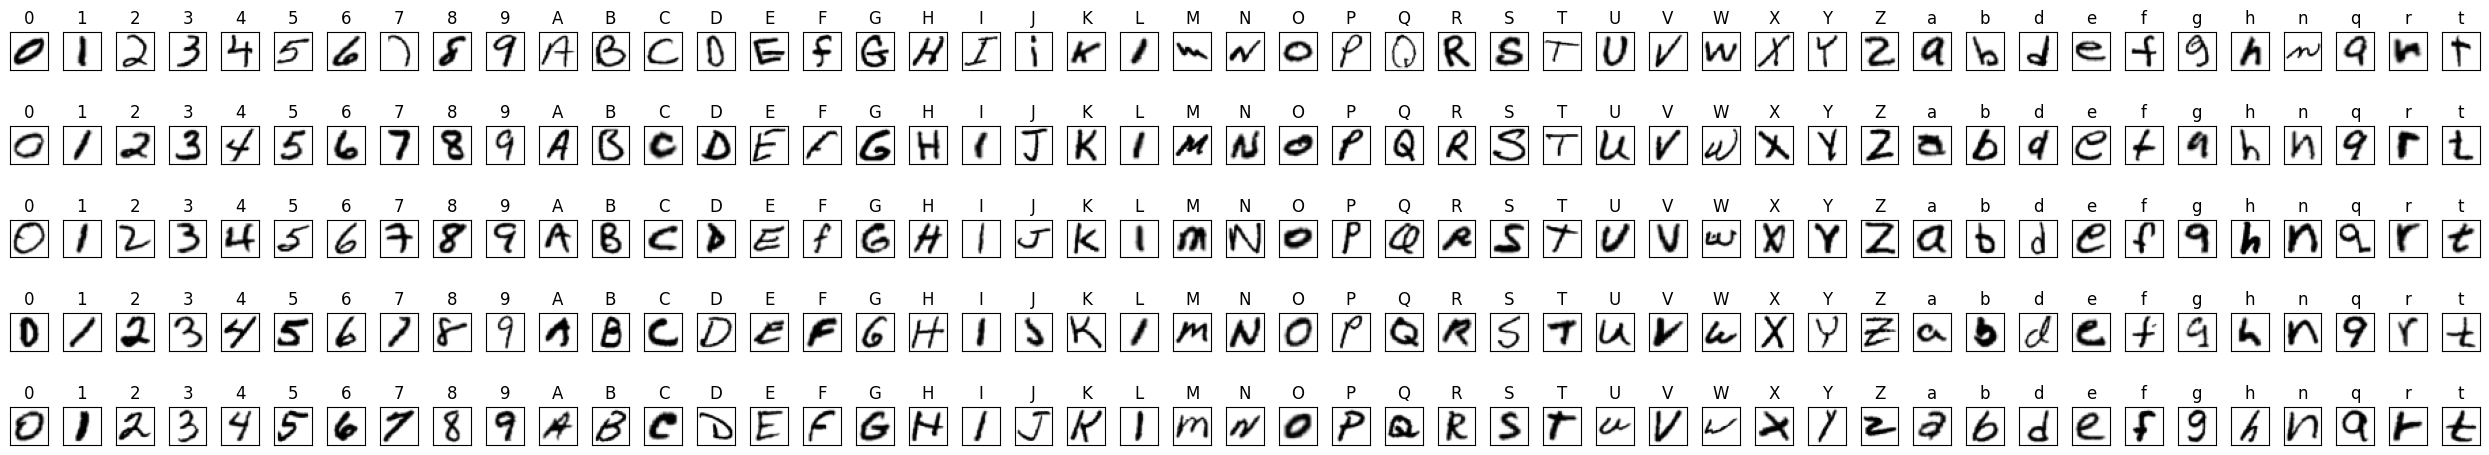

In [4]:
# Get unique classes
classes = np.unique(y)

# Sample 5 indices for each class
sampled_indices = {c: np.random.choice(np.where(y==c)[0], 5) for c in classes} 

# Setup grid
nrows = 5
ncols = len(classes) 

# Plot images
fig, axes = plt.subplots(nrows, ncols, figsize=(25, 5))

for c, indices in sampled_indices.items():
  for r in range(nrows):
    i = indices[r]
    ax = axes[r, c]

    img, label = data[i]
    img = img.squeeze() 
    label = data.classes[label]
     
    ax.imshow(np.rot90(np.fliplr(img)), cmap='binary')
    ax.set_title(label)

    ax.set_xticks([])
    ax.set_yticks([])

plt.tight_layout()
plt.show()

In [5]:
def plot_learning_curves(estimator, label, X, y, axes=None, ymax=None, n_jobs=None, cv=None):
    common_params = {
        "X": X,
        "y": y,
        "train_sizes": np.linspace(0.1, 1.0, 5),
        "cv": cv,
        "n_jobs": n_jobs,
        "return_times": True,
    }

    if axes is None:
        _, axes = plt.subplots(1, 3, figsize=(15, 5))

    axes[0].set_title(label)
    if ymax is not None:
        axes[0].set_ylim(*ymax)
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel("Score")

    train_count, train_scores, test_scores, time_to_fit, _ = learning_curve(estimator, **common_params)

    train_mean = np.mean(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    fit_mean = np.mean(time_to_fit, axis=1)

    axes[0].grid()
    axes[0].plot(train_count, train_mean, color="b", label="Training")
    axes[0].plot(train_count, test_mean, color="r", label="Cross-validation")
    axes[0].legend(loc="best")

    axes[1].grid()
    axes[1].plot(train_count, fit_mean, color="g")
    axes[1].set_xlabel("Training examples")
    axes[1].set_ylabel("Time to Fit")
    axes[1].set_title("Scalability")

    axes[2].grid()
    axes[2].plot(fit_mean, test_mean, color="b")
    axes[2].set_xlabel("Time to Fit")
    axes[2].set_ylabel("Score")
    axes[2].set_title("Performance")

    return plt


In [6]:
class MaximumLikelihoodClassifier(BaseEstimator):
    def __init__(self, num_classes= 47, pseudo_count=1e-12):
        self.num_classes = num_classes
        self.pseudo_count = pseudo_count
        self.class_priors = None
        self.pixel_probabilities = []

    def fit(self, X, y):
        self.class_priors = [Counter(y)[i] / len(y) for i in range(self.num_classes)]
        for c in range(self.num_classes):
            X_type = X[y == c]
            class_probabilities = np.mean(X_type, axis=0)
            self.pixel_probabilities.append(class_probabilities)

    def predict(self, X):
        y_pred = []
        for i in range(len(X)):
            image = X[i]
            class_scores = [self.calculate_class_score(image, c) for c in range(self.num_classes)]
            y_pred.append(np.argmax(class_scores))
        return y_pred

    def calculate_class_score(self, image, c):
        means = self.pixel_probabilities[c]
        prob_est = np.sum(image * np.log(means + self.pseudo_count) + (1 - image) * np.log(1 - means + self.pseudo_count))
        posterior = prob_est + np.log(self.class_priors[c])
        return posterior

    # def score(self, X, y):
    #     log_likelihood = []
    #     for i in range(len(X)):
    #         image = X[i]
    #         c = y[i]
    #         class_scores = self.calculate_class_score(image, c)
    #         log_likelihood.append(class_scores)
    #     return np.mean(log_likelihood)
    def score(self, X, y):
        
      log_likelihood_mle = 0
        
      for i in range(len(X)):
          
          image = X[i]
          c = y[i]
            
          # Calculate MLE score
          log_likelihood_pixel = self.calculate_class_score(image, c)
          log_likelihood_mle += log_likelihood_pixel
          
          
      N = len(X)  
      score_mle = log_likelihood_mle / N
      
      return score_mle


In [7]:
class MaximumAPosterioriClassifier(BaseEstimator):
    def __init__(self, alpha, beta, classes=47, pseudo_count=1e-20):
        self.classes = classes
        self.num_pixels = 28
        self.alpha = alpha
        self.beta = beta
        self.pixel_probabilities = [] 
        self.class_prior = []
        self.dist = []
        self.pseudo_count = pseudo_count
    
    def fit(self, X, y):
        self.dist = [Counter(y)[i] / len(y) for i in range(self.classes)]
        alpha_1 = self.generate_alphas()
        self.class_prior = self.mode(alpha_1)

        for c in range(self.classes):
            ones = np.zeros((self.num_pixels, self.num_pixels))
            sample_index = (y == c)
            X_type = X[sample_index]
            for i in range(len(X_type)):
                ones += X_type[i]
            zeros = len(X_type) - ones 
            self.pixel_probabilities.append(self.calculate_probabilities(ones, zeros))
    
    def calculate_probabilities(self, ones, zeros):
        a, b = self.beta
        n = zeros + b
        m = ones + a
        pixel_probabilities = (m - 1) / (m + n - 2)
        return pixel_probabilities

    def generate_alphas(self, alpha=None):
        if alpha is None:
            alpha = self.alpha
        return np.add(alpha, self.dist)
    
    def mode(self, alpha):
        return ((alpha - 1) / (sum(alpha) - self.classes))

    def predict(self, X):
        y_pred = []
        for i in range(len(X)):
            class_scores = []
            image = X[i]
            for c in range(self.classes):
                means = self.pixel_probabilities[c] 
                prob_est = 0
                class_scores, temp = self.get_probabilities(image, class_scores, means, prob_est, c)
            y_pred.append(np.argmax(class_scores)) 
        return y_pred

    def get_probabilities(self, image, class_scores, means, prob_est, c):
        image_array = np.array(image)
        means_array = np.array(means)
        prob_est += np.sum(image_array * np.log(means_array + self.pseudo_count) + (1 - image_array) * np.log(1 - means_array + self.pseudo_count))
        posterior = prob_est + np.log(self.class_prior[c])
        class_scores.append(posterior)
        return class_scores, prob_est

    def score(self, X, y):
        log_likelihood = []
        for i in range(len(X)):
            class_scores = []
            c = y[i]
            image = X[i]
            means = self.pixel_probabilities[c]
            class_scores, prob_est = self.get_probabilities(image, class_scores, means, log_likelihood, c)
            log_likelihood = np.sum(prob_est)
        dataset_size = len(X)
        score = log_likelihood / dataset_size
        return score


In [8]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.90, random_state=0)

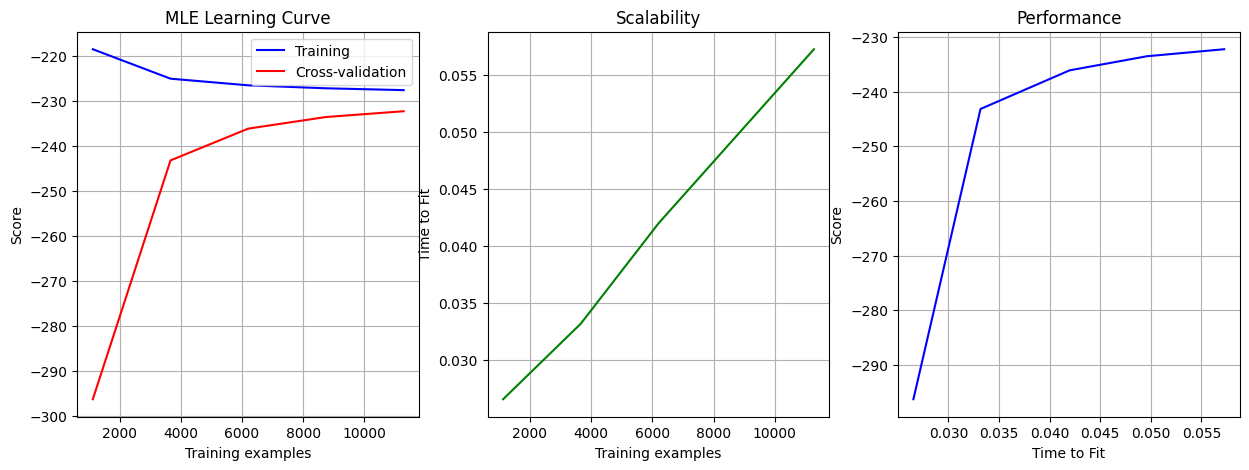

In [9]:
mle = MaximumLikelihoodClassifier()
mle.fit(X_train, y_train)
mle.predict(X_train)
cv = ShuffleSplit(n_splits=12,test_size=0.90,random_state=0)
plt = plot_learning_curves(mle, 'MLE Learning Curve', X, y, n_jobs=1,cv=cv)
plt.show()

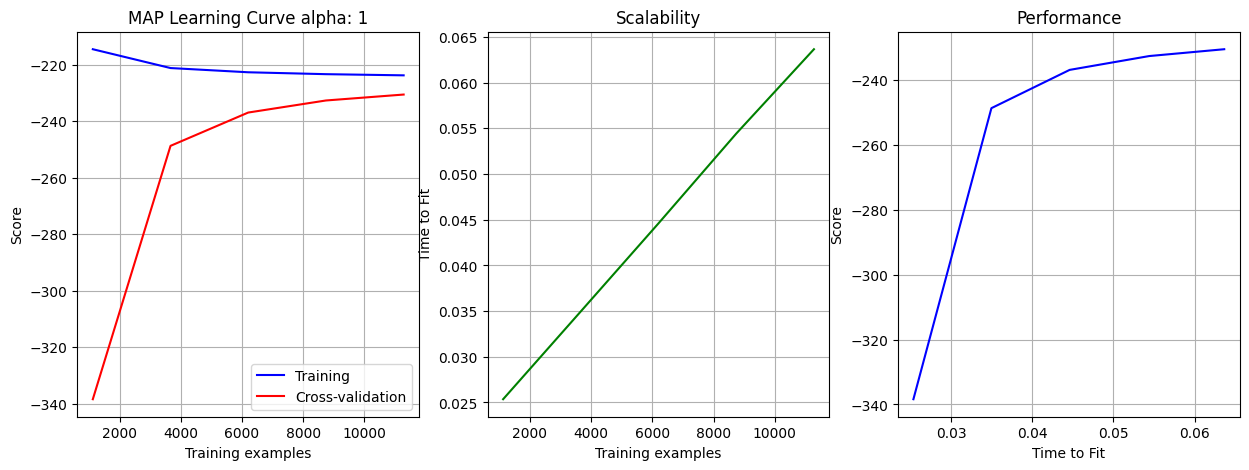

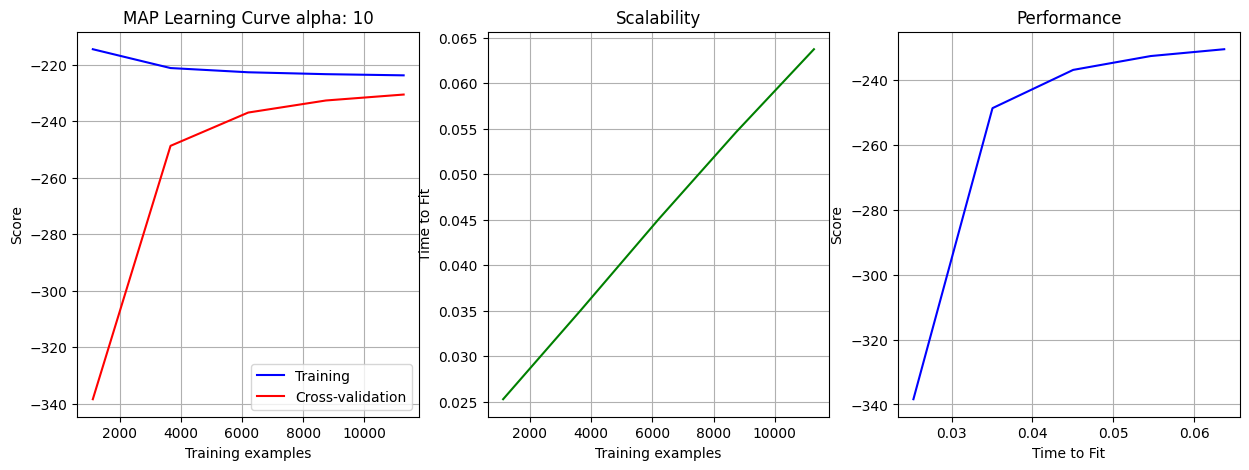

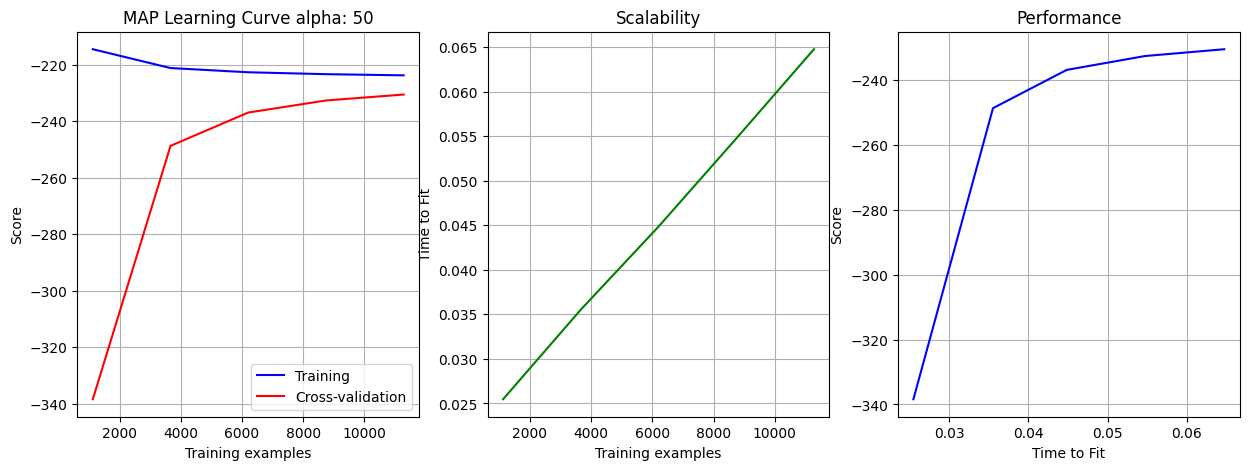

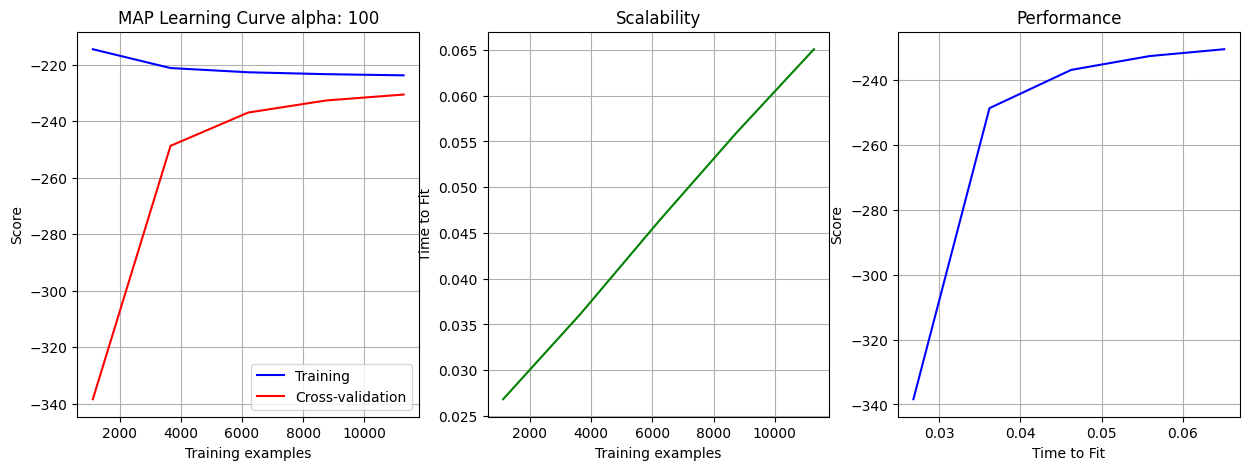

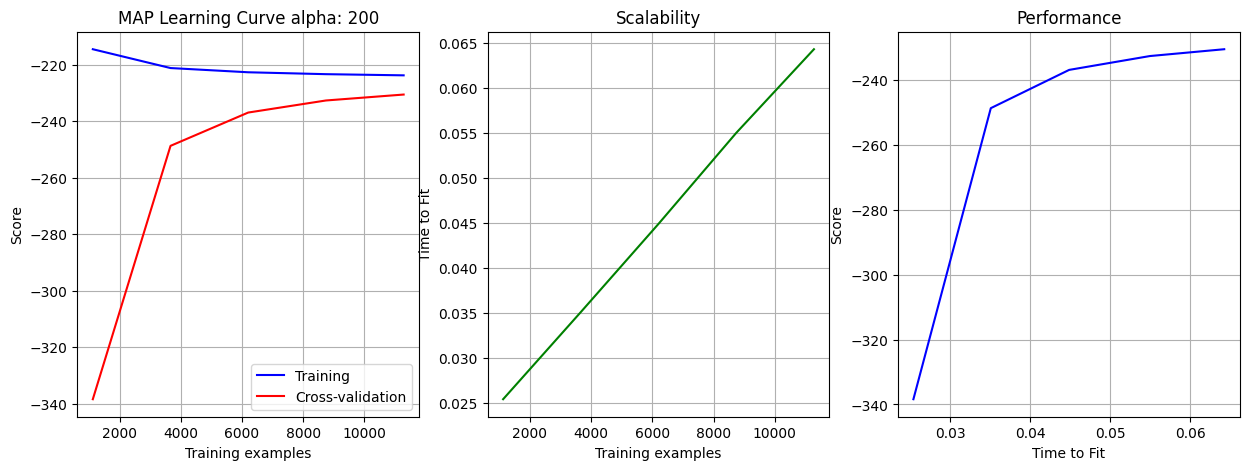

In [10]:
for a in (1, 10, 50, 100, 200):
    map = MaximumAPosterioriClassifier(alpha=[a] * 47, beta=[1, 1])
    map.fit(X_train, y_train)
    map.predict(X_train)
    cv = ShuffleSplit(n_splits=12,test_size=0.9,random_state=0)
    plt = plot_learning_curves(map, f'MAP Learning Curve alpha: {a}', X, y, n_jobs=1,cv=cv)
    plt.show()

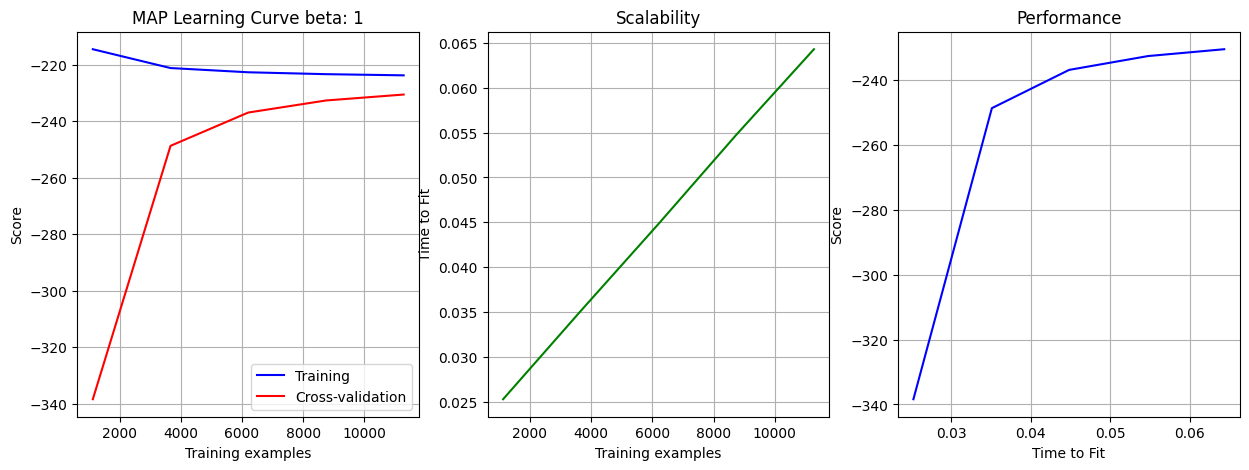

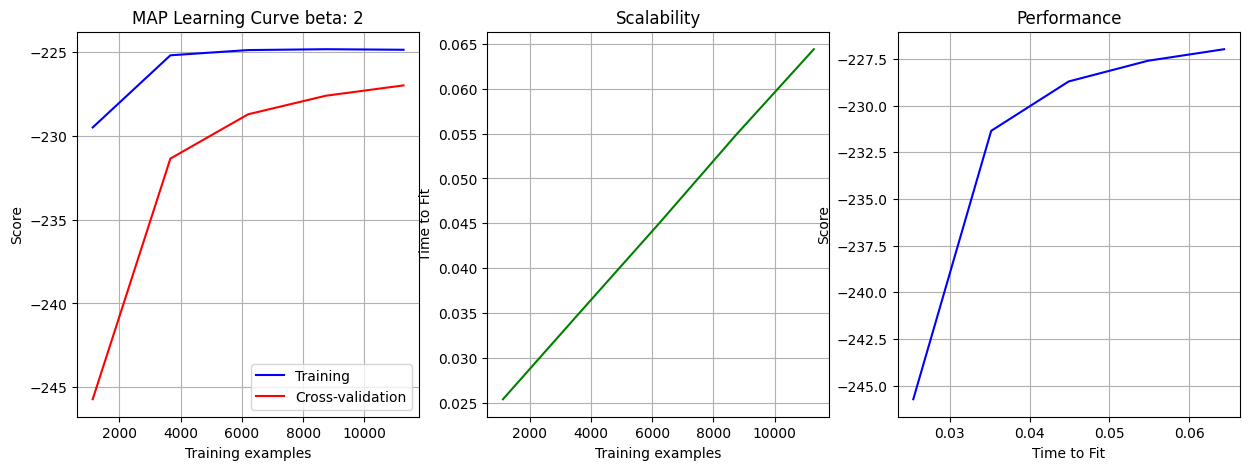

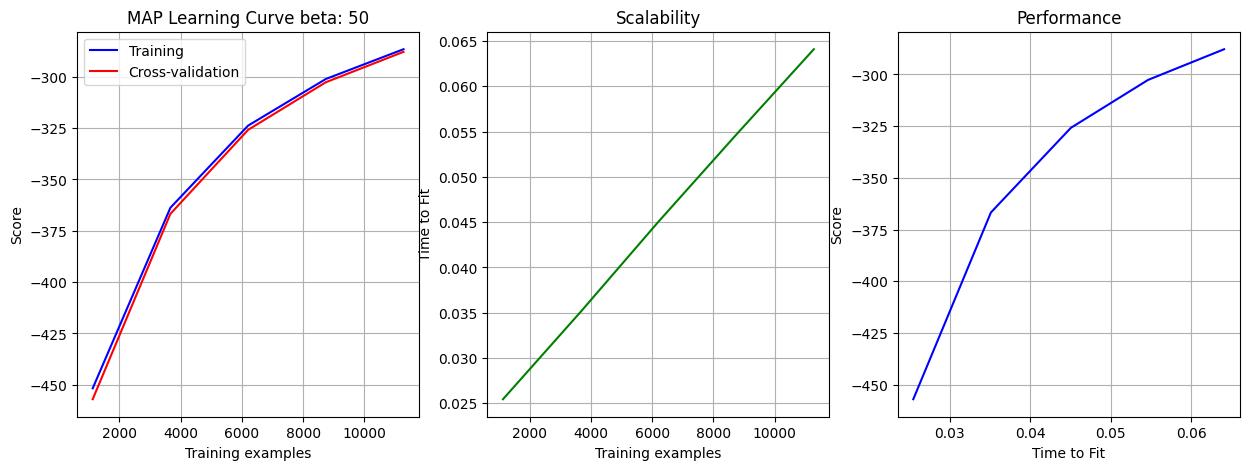

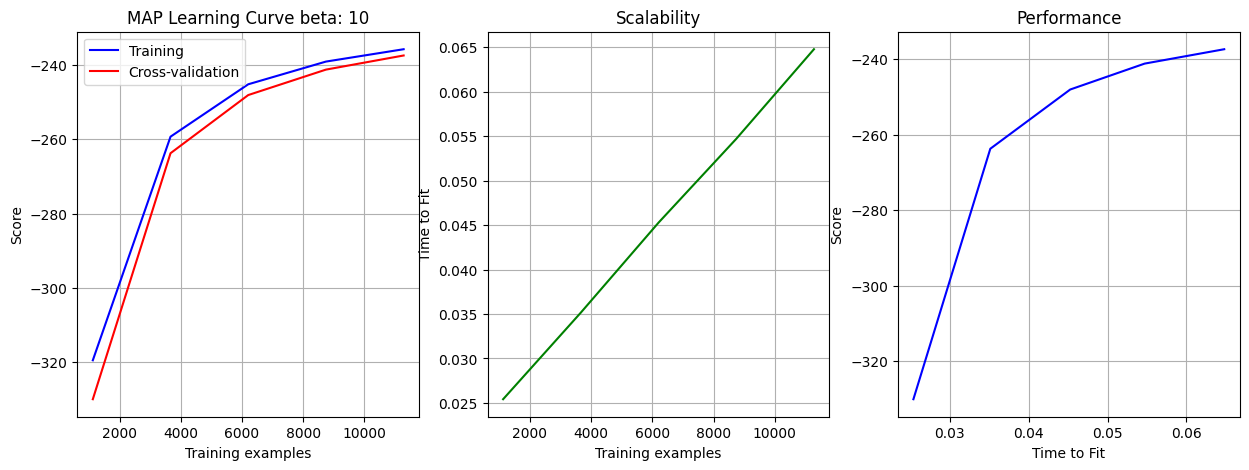

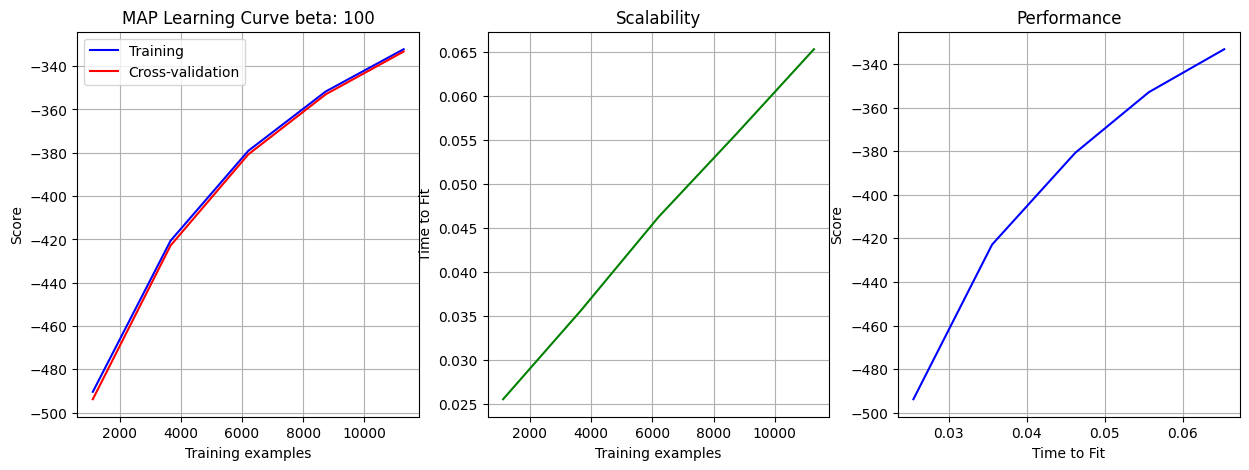

In [11]:
for b in (1, 2, 50, 10, 100):
    map = MaximumAPosterioriClassifier(alpha=[1] * 47, beta=[b, b])
    map.fit(X_train, y_train)
    map.predict(X_train)
    cv = ShuffleSplit(n_splits=12,test_size=0.9,random_state=0)
    plt = plot_learning_curves(map, f'MAP Learning Curve beta: {b}', X, y, n_jobs=1,cv=cv)
    plt.show()

In [12]:
from sklearn.model_selection._split import BaseShuffleSplit, _validate_shuffle_split, check_random_state
from sklearn.utils.validation import _num_samples

class CustomShuffleSplit(BaseShuffleSplit):
    def __init__(self, n_splits=10, *, test_size=None, train_size=None, random_state=None, y=None, alpha_class=None):
        super().__init__(
            n_splits=n_splits,
            test_size=test_size,
            train_size=train_size,
            random_state=random_state,
        )
        self._default_test_size = 0.1
        self._y = y
        self._alpha_class = alpha_class

    def _imbalanced_sampling(self, train_indices, y, alpha_class):
        y_train = y[train_indices]
        class_freq_dict = Counter(y_train)
        dist = (np.random.dirichlet([alpha_class] * 47 , 1) * train_indices.shape[0]).astype(int).flatten()
        dist[dist == 0] = np.random.choice([1, 2, 3])
        for index, item in enumerate(dist):
            if dist[index] > class_freq_dict[index]:
                dist[index] = class_freq_dict[index]
        label_index_dict = {}
        for index, label in enumerate(y_train):
            label_index_dict[label] = label_index_dict.get(label, []) + [index]
        sampled_indices = []
        for label, num_samples in enumerate(dist):
            sampled_indices.extend(random.sample(label_index_dict[label], num_samples))
        return sampled_indices

    def _iter_indices(self, X, y=None, groups=None):
        n_samples = _num_samples(X)
        n_train, n_test = _validate_shuffle_split(
            n_samples,
            self.test_size,
            self.train_size,
            default_test_size=self._default_test_size,
        )

        rng = check_random_state(self.random_state)
        for i in range(self.n_splits):
            # random partition
            permutation = rng.permutation(n_samples)
            ind_test = permutation[:n_test]
            ind_train = permutation[n_test : (n_test + n_train)]
            # ind_train = self._imbalanced_sampling(train_indices=ind_train, y=self._y, alpha_class=self._alpha_class)
            ind_train = self._imbalanced_sampling(ind_train, self._y, self._alpha_class)

        yield ind_train, ind_test

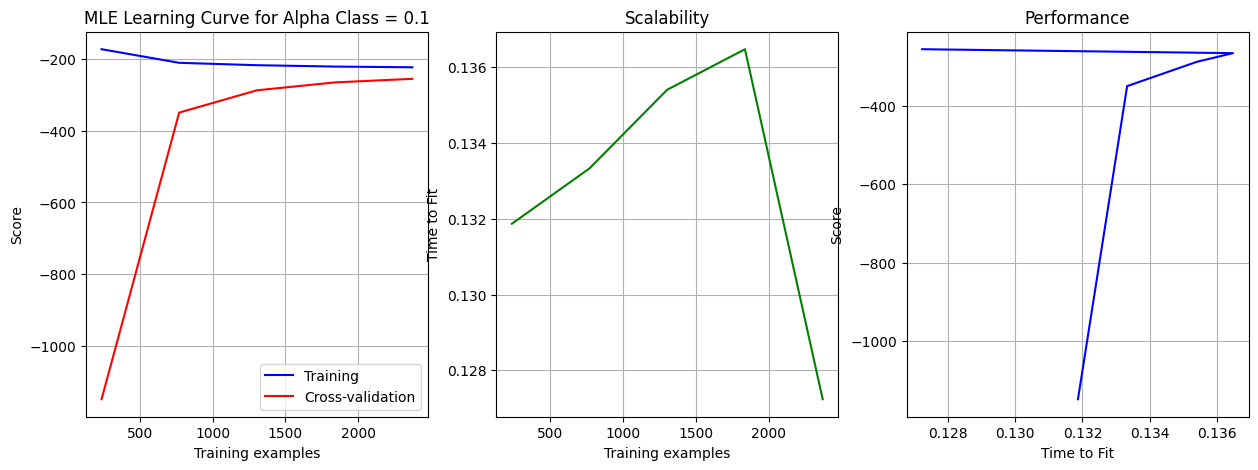

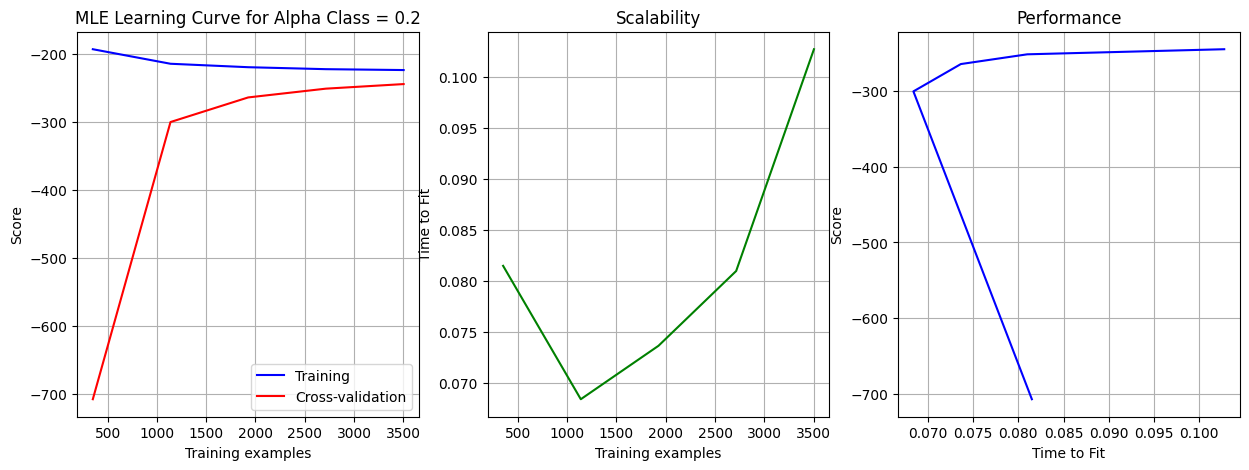

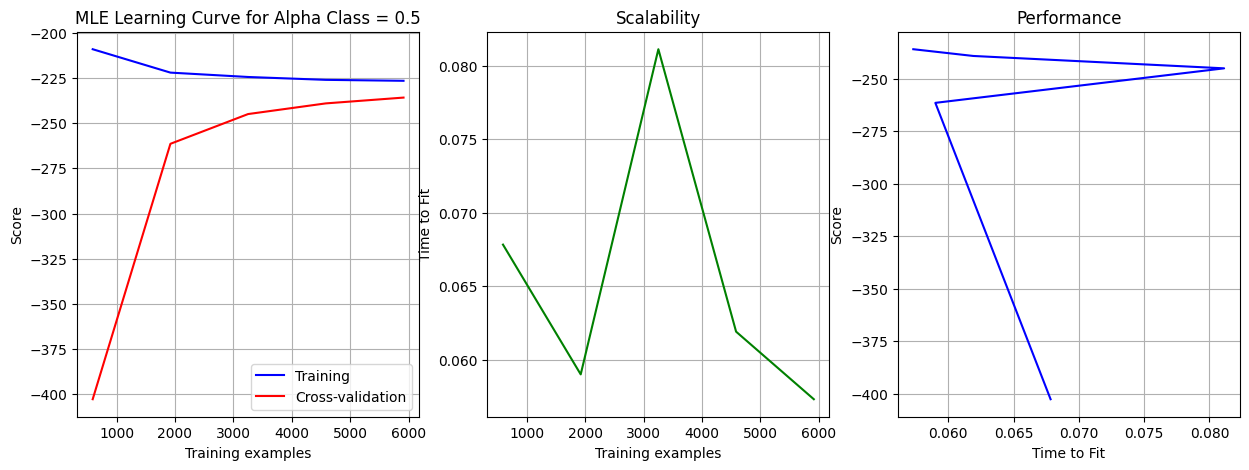

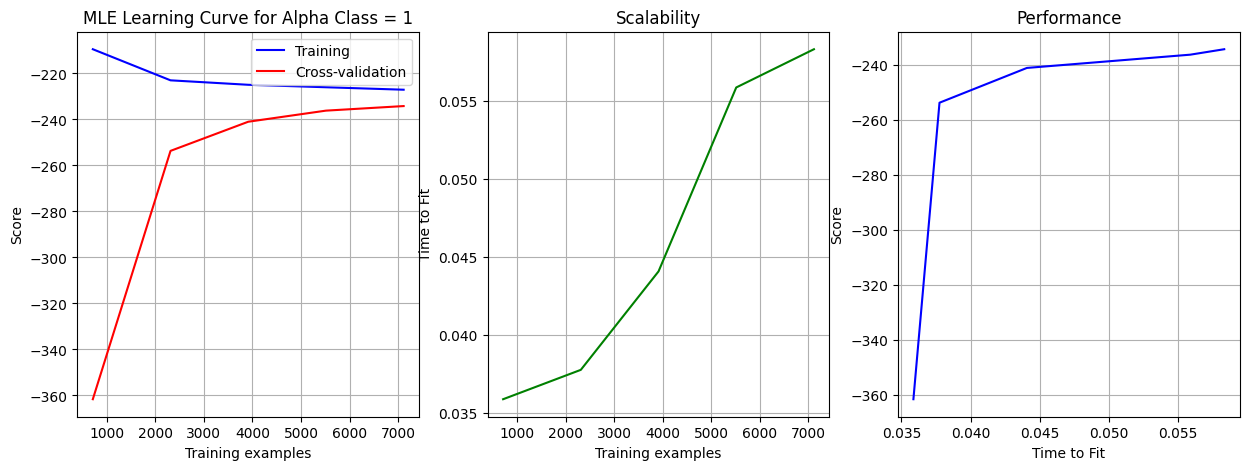

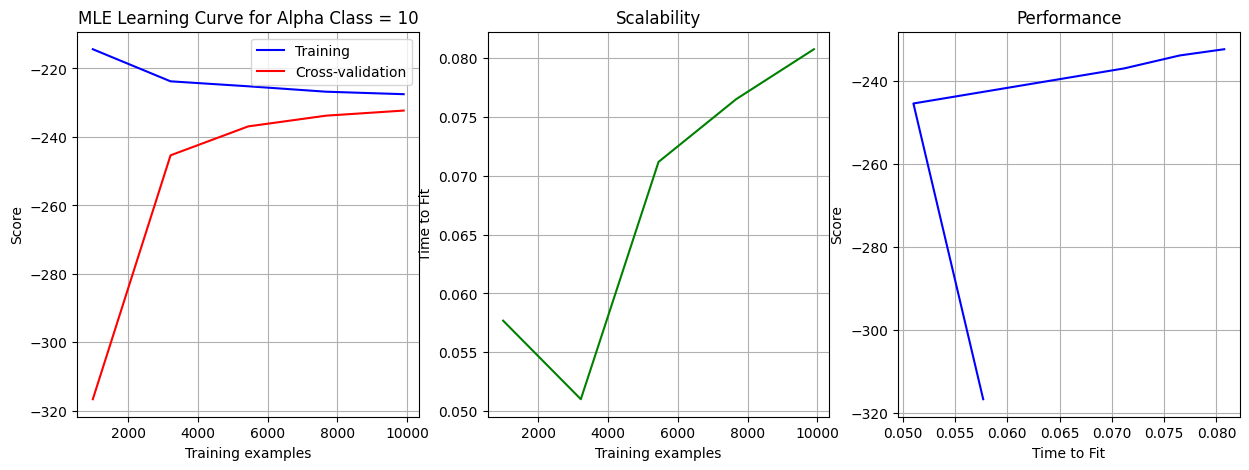

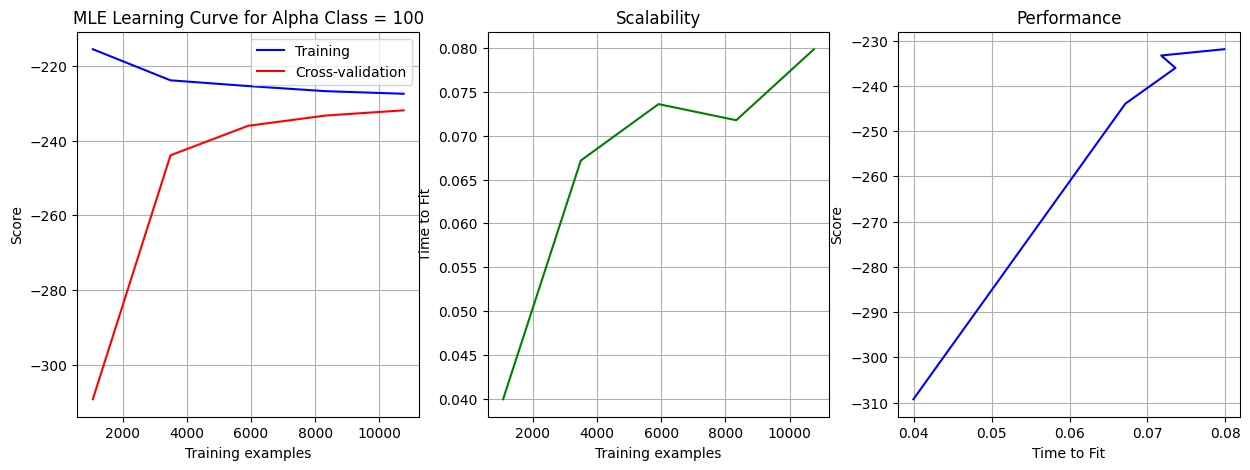

In [13]:
for alpha_class_itr in (0.1, 0.2, 0.5, 1, 10, 100):
    mle_imb = MaximumLikelihoodClassifier()
    mle_imb.fit(X_train, y_train)
    mle_imb.predict(X_train)
    customSplit = CustomShuffleSplit(n_splits=12, test_size=0.9, train_size=0.1, 
                                      random_state=0, y=y, alpha_class=alpha_class_itr)
    plt = plot_learning_curves(mle_imb, f'MLE Learning Curve for Alpha Class = {alpha_class_itr}', 
                     X, y, n_jobs=-1,cv=customSplit)
    plt.show()

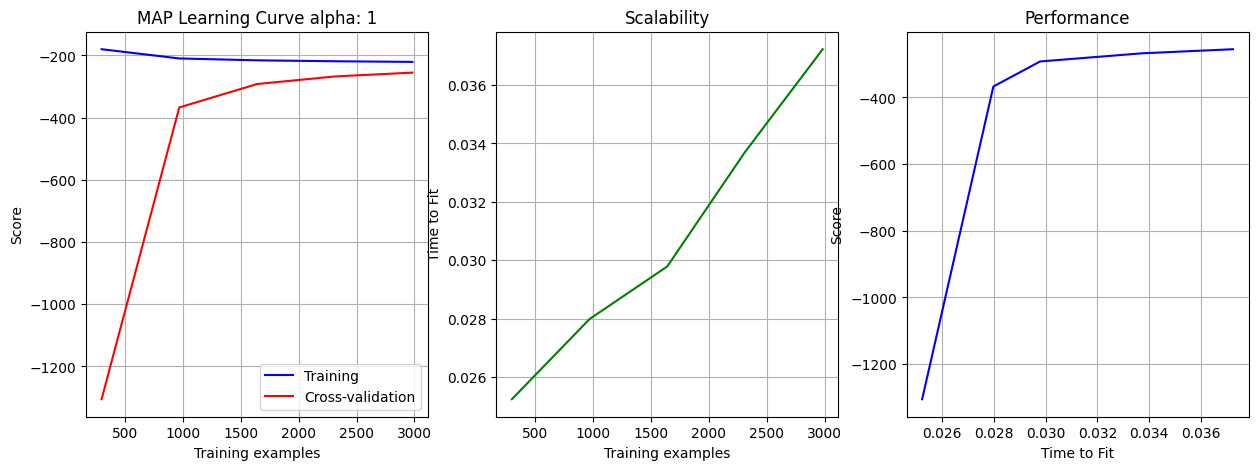

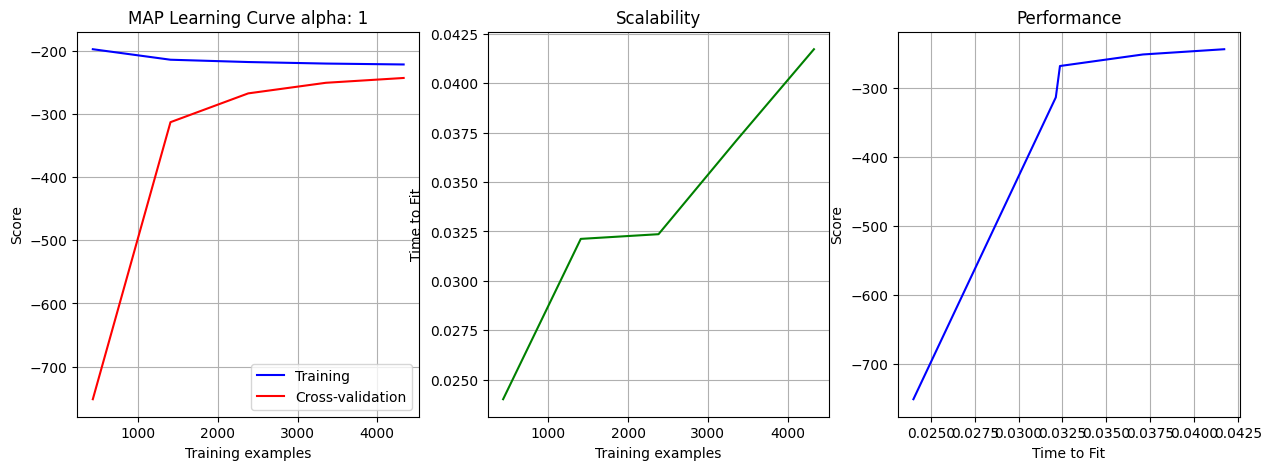

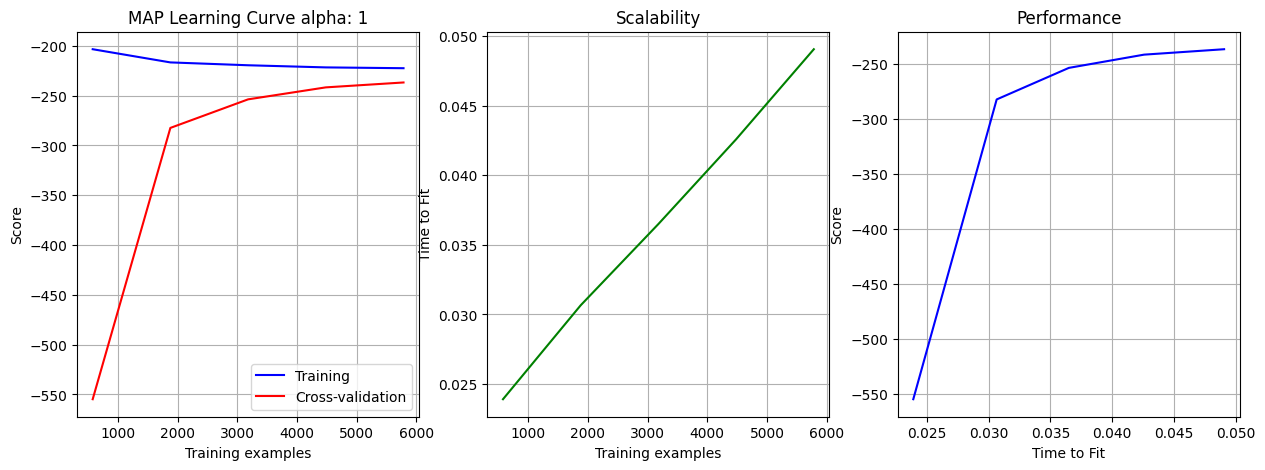

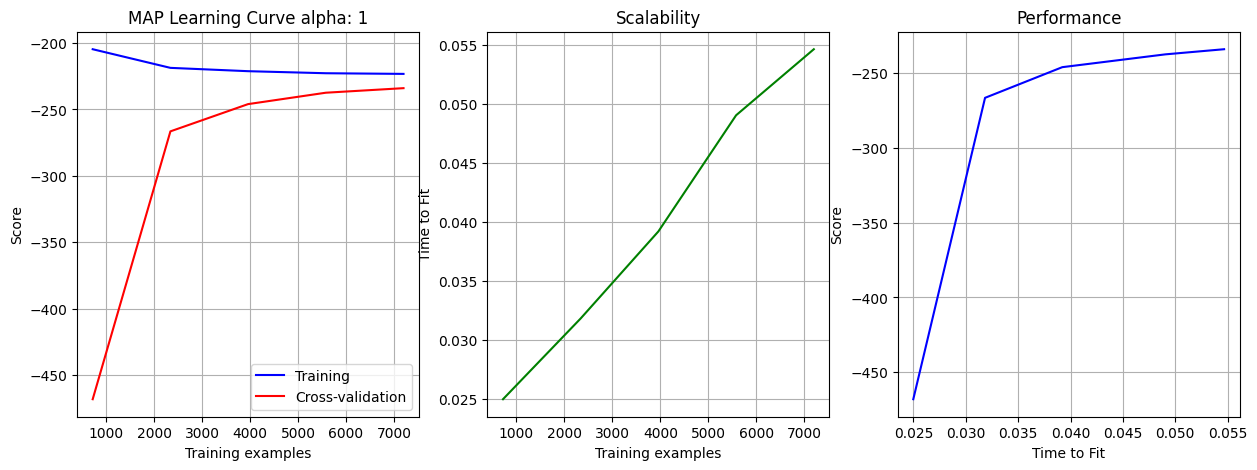

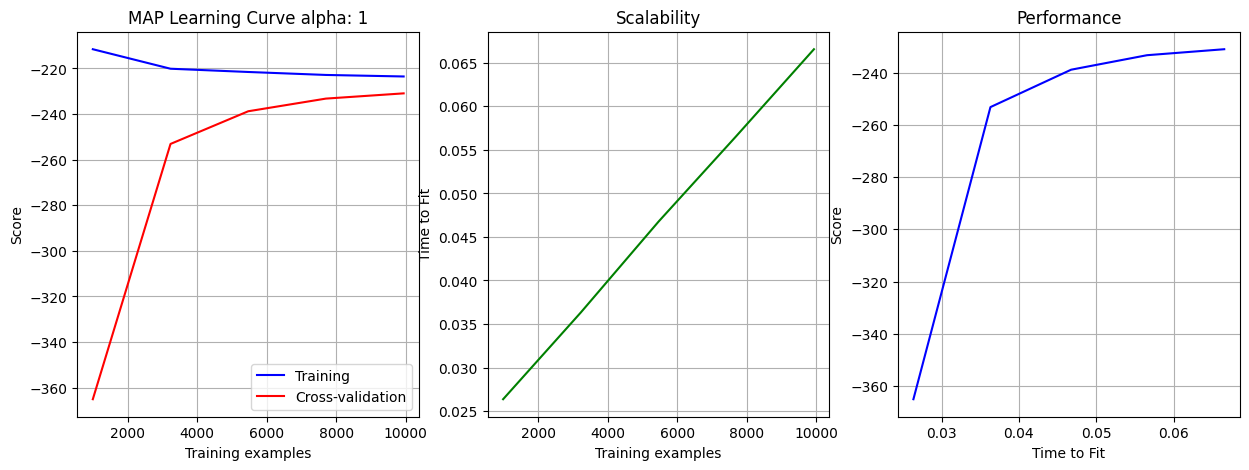

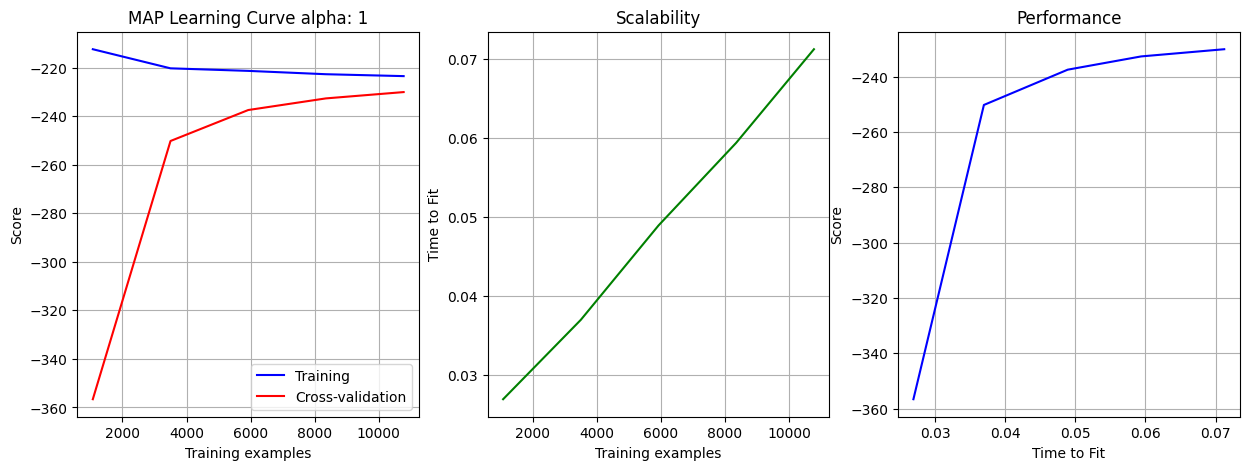

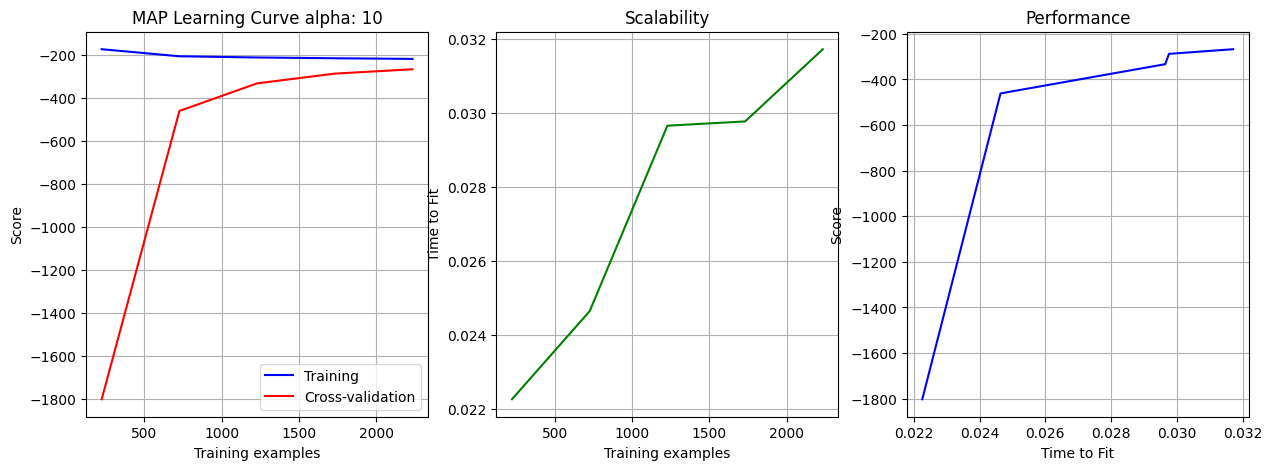

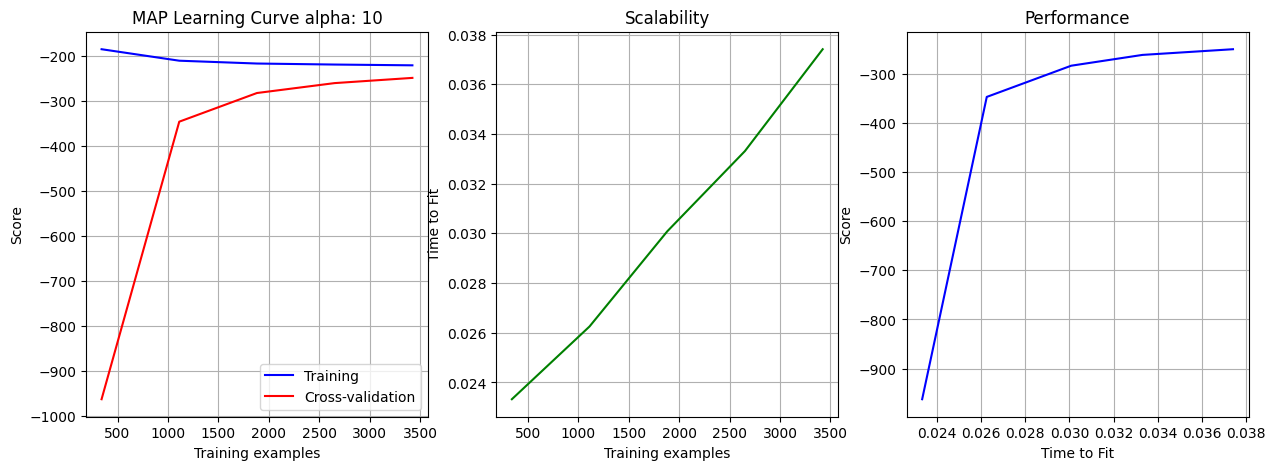

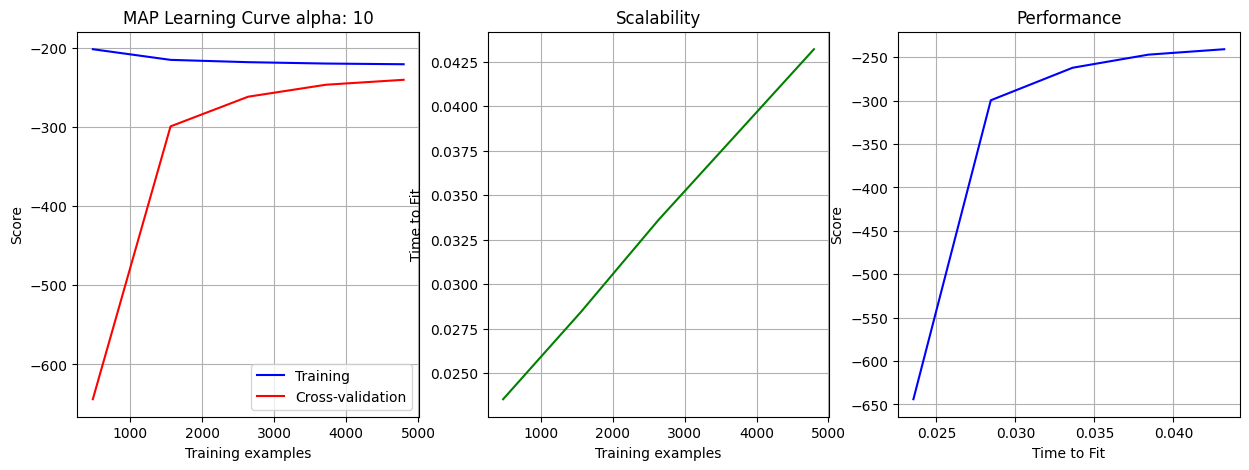

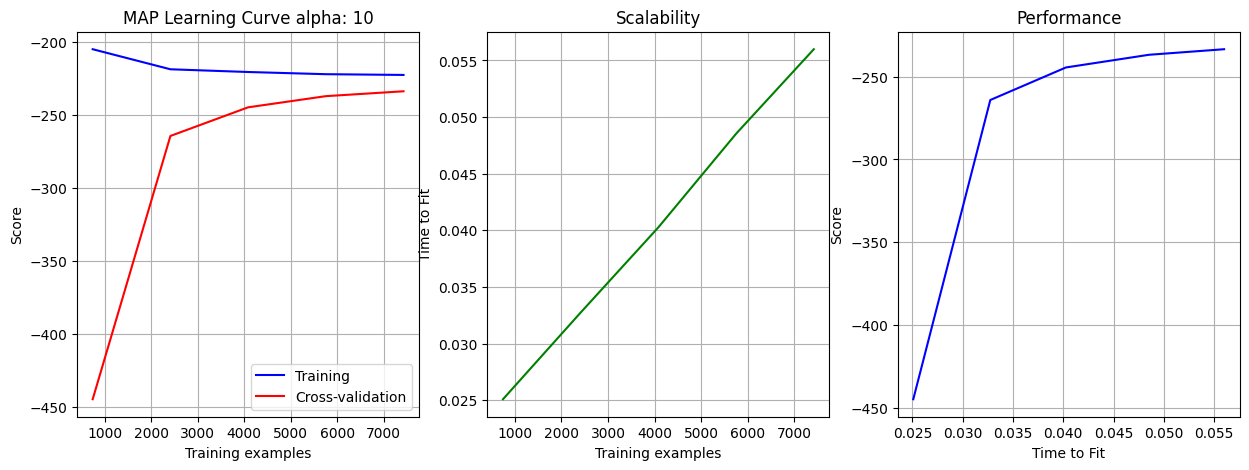

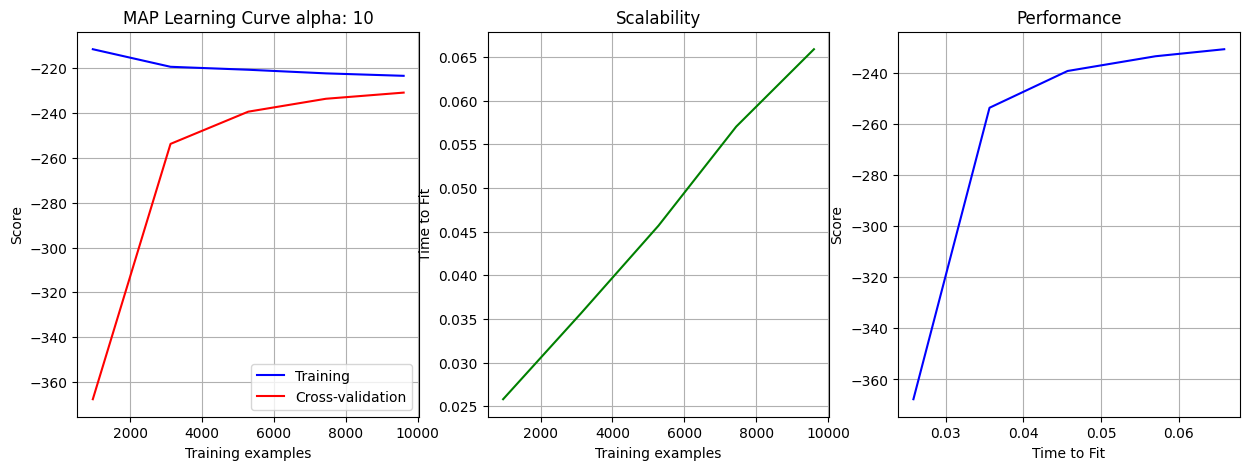

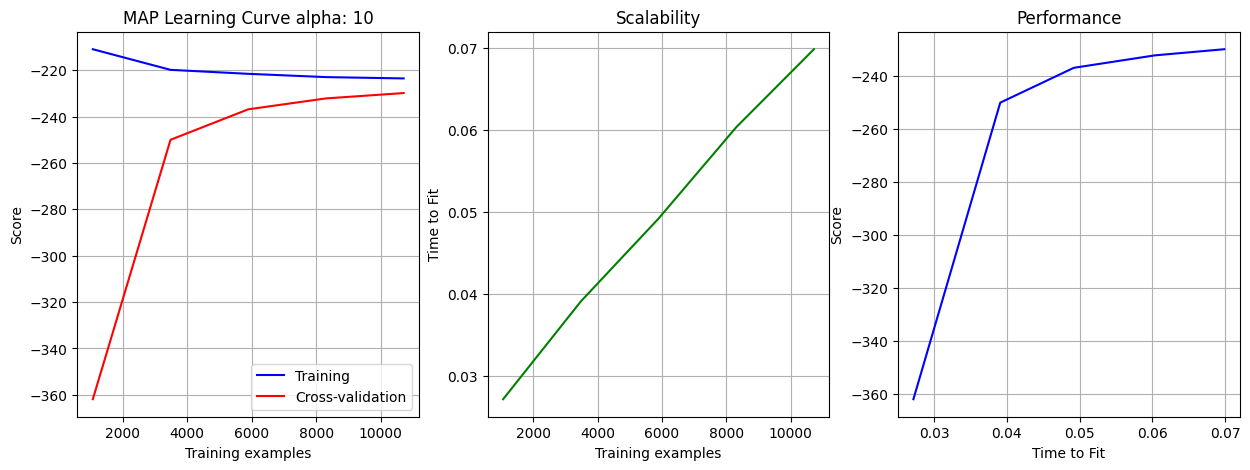

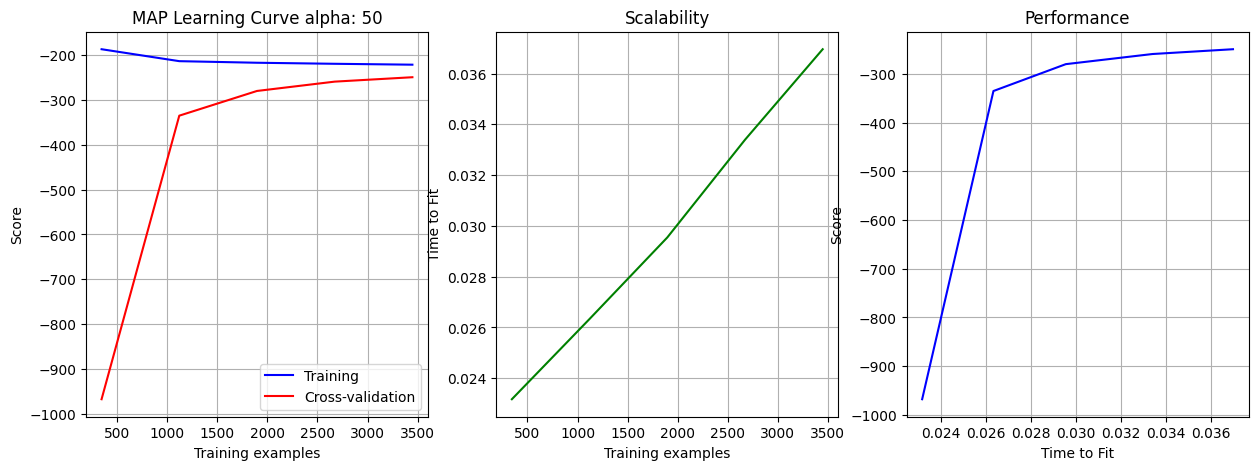

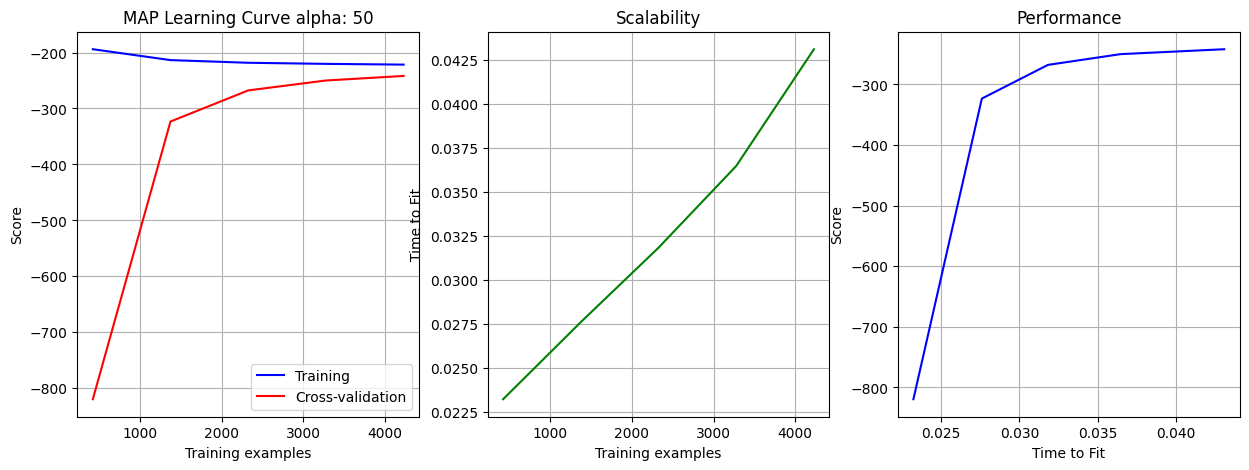

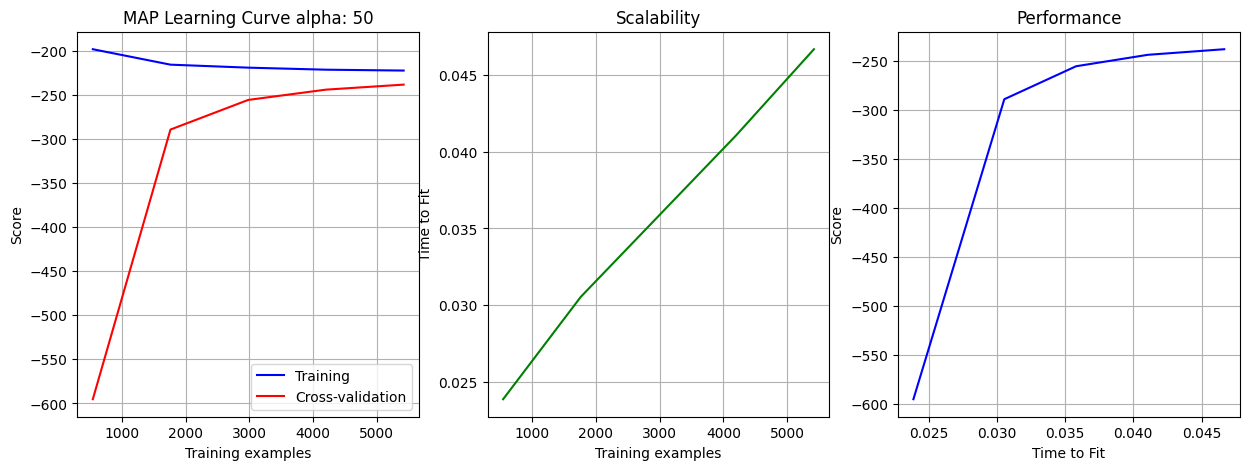

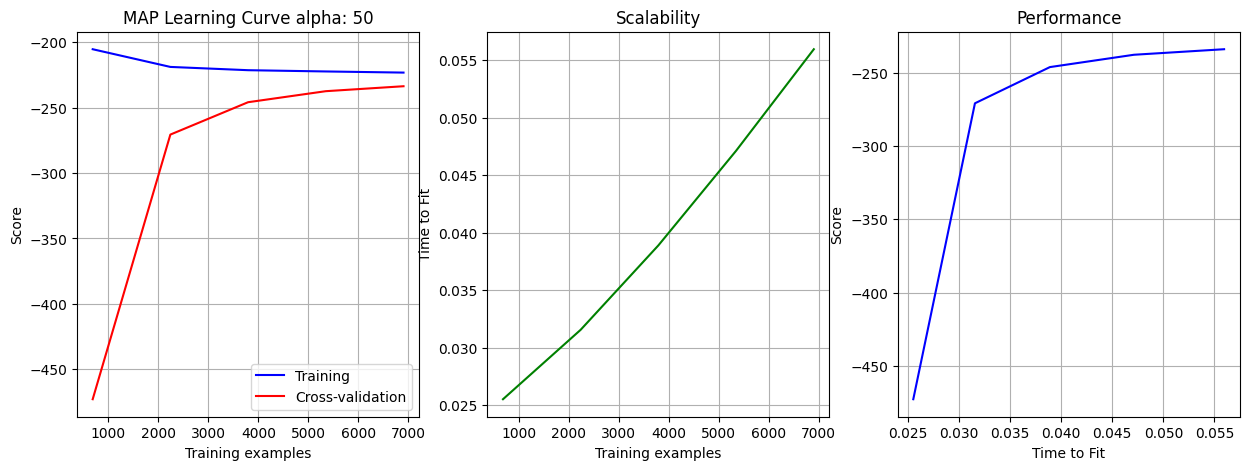

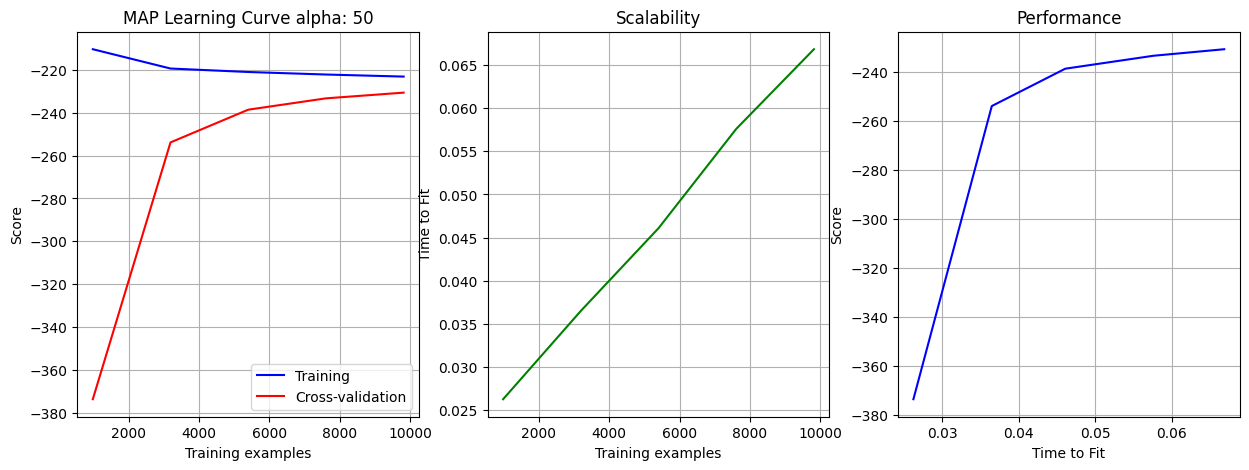

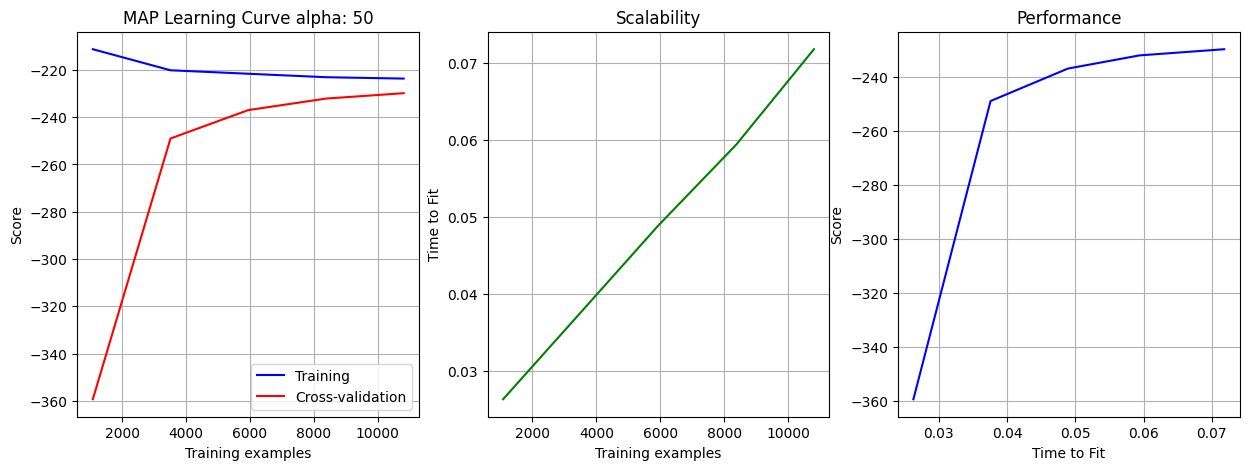

/var/folders/1c/flplcvwd7td1z95vc702_4fh0000gp/T/ipykernel_67977/1090731603.py:30: RuntimeWarning: invalid value encountered in divide
  pixel_probabilities = (m - 1) / (m + n - 2)


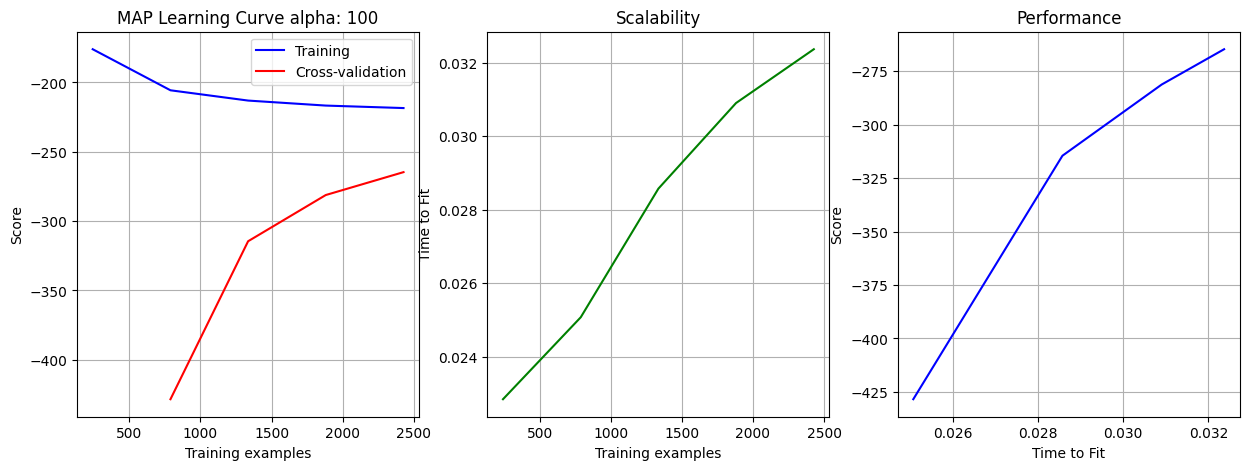

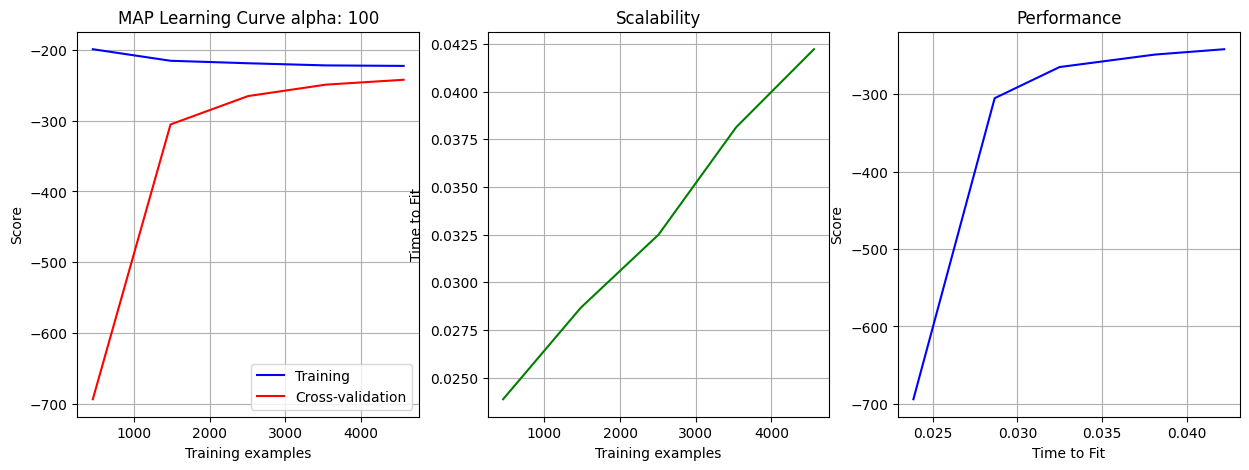

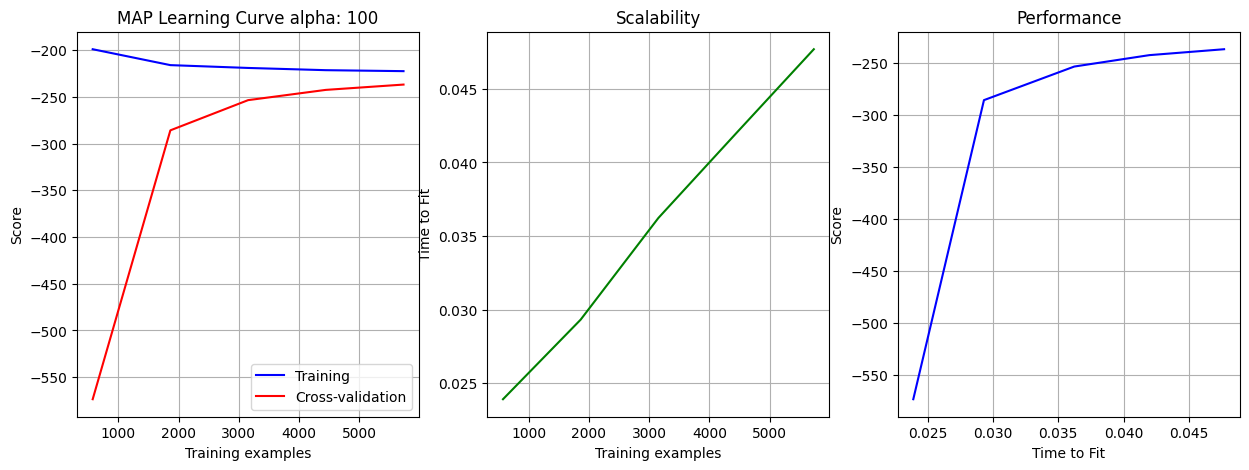

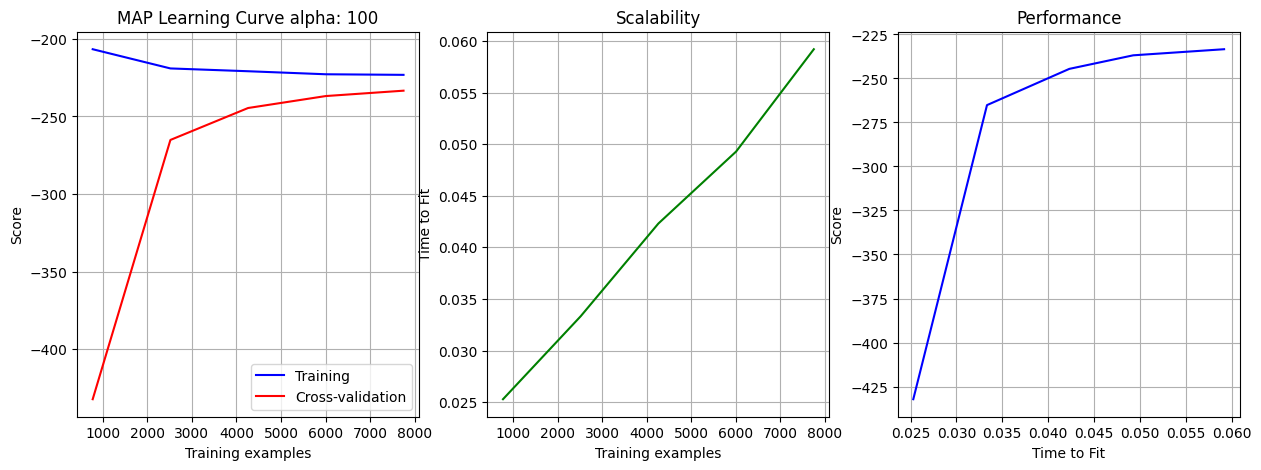

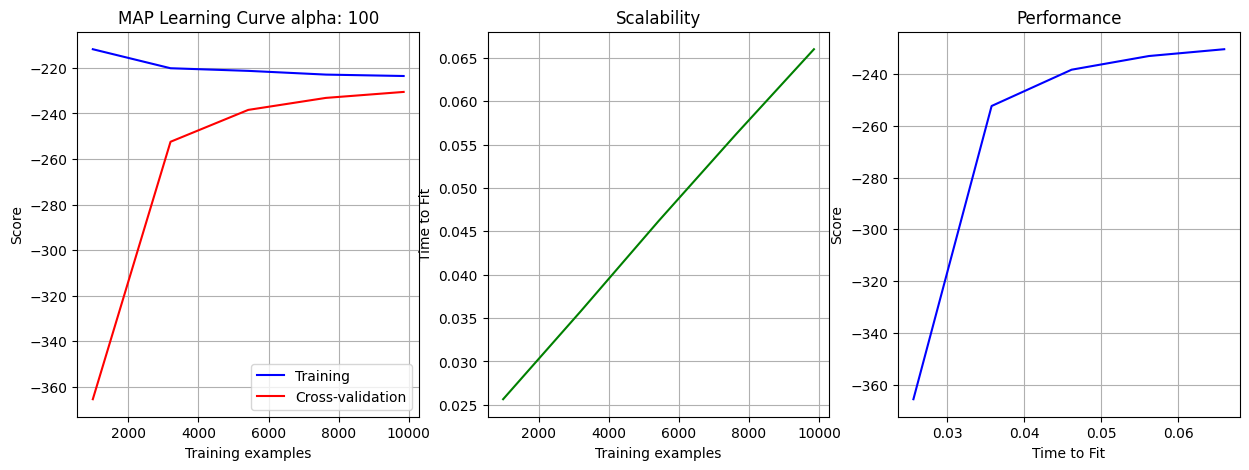

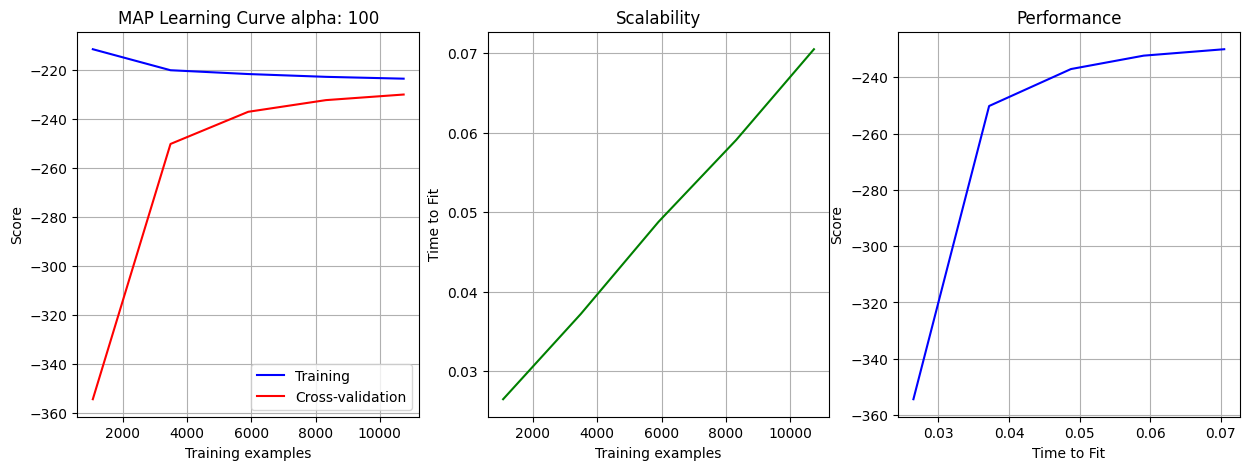

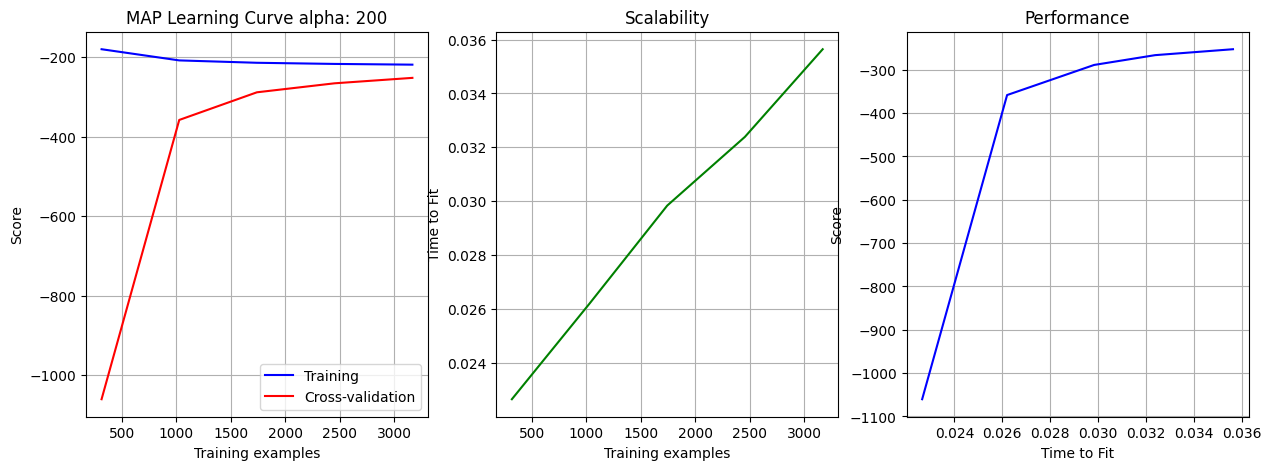

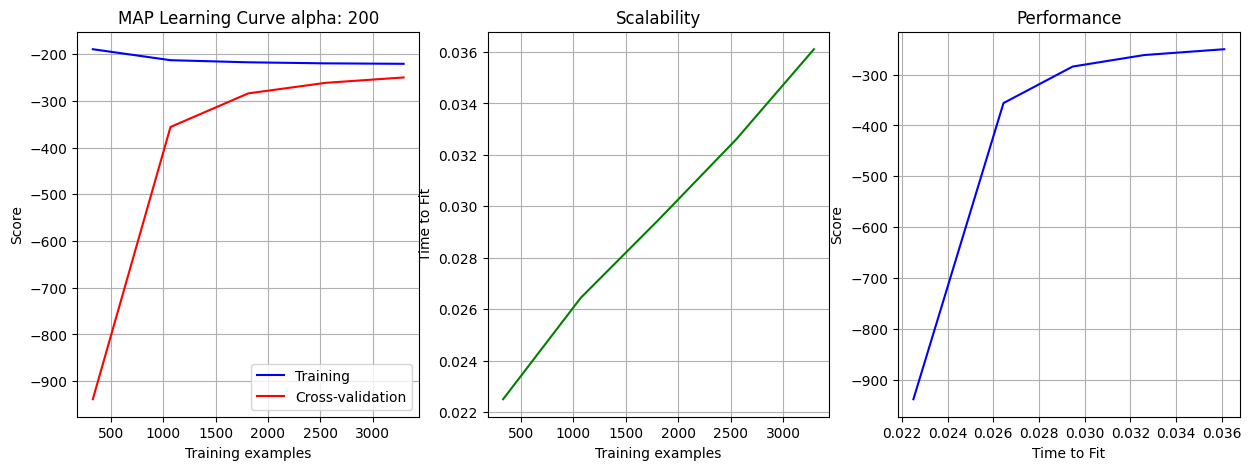

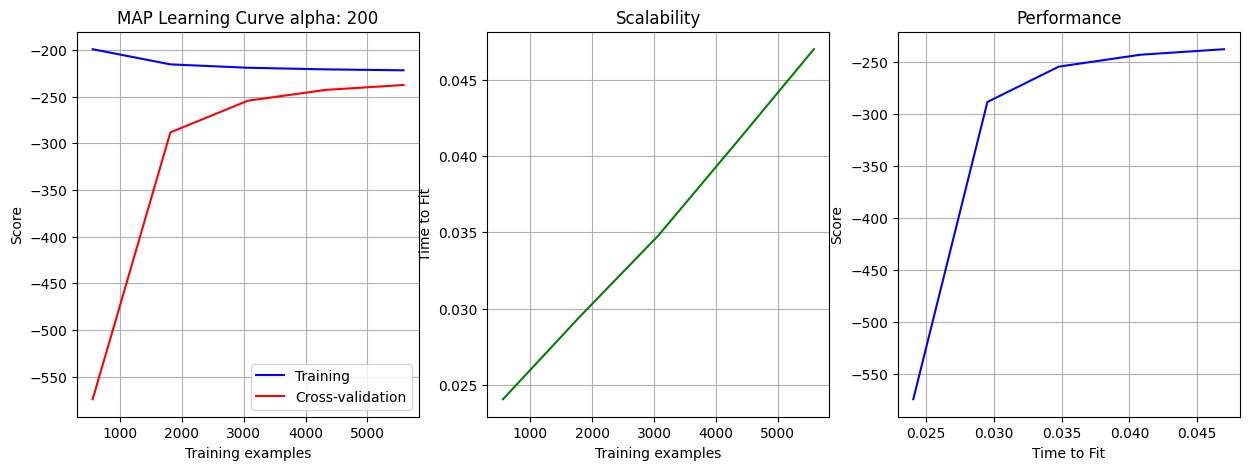

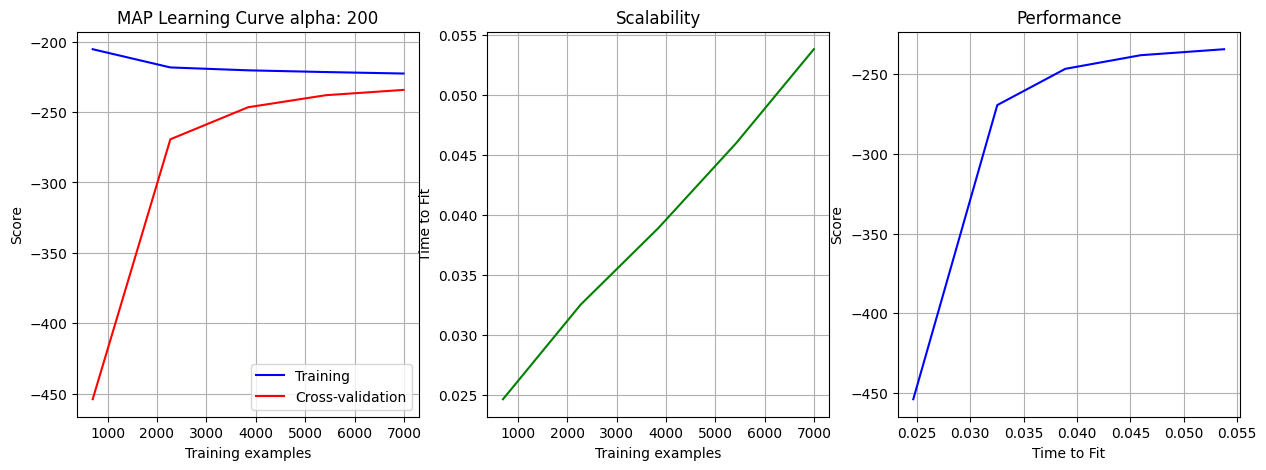

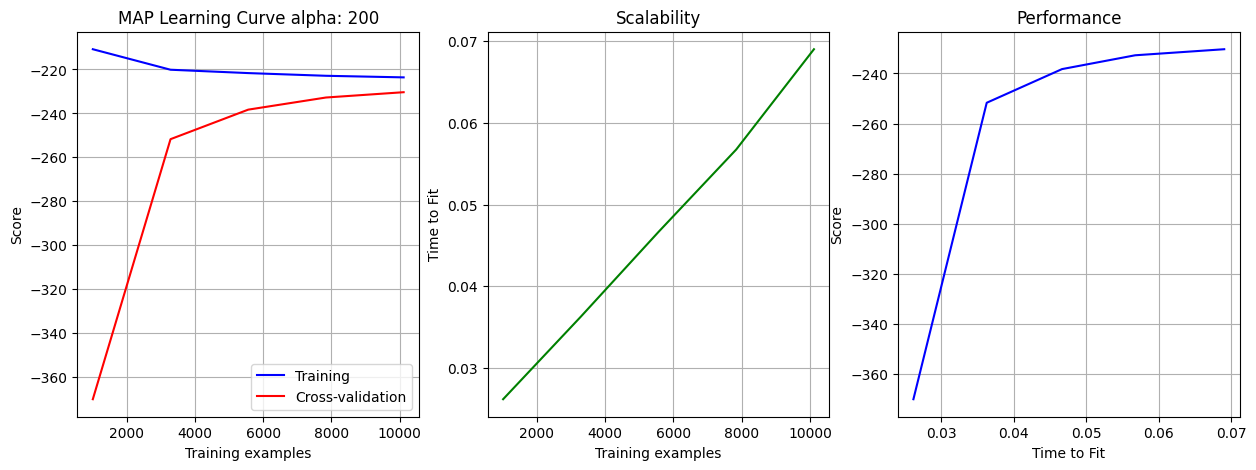

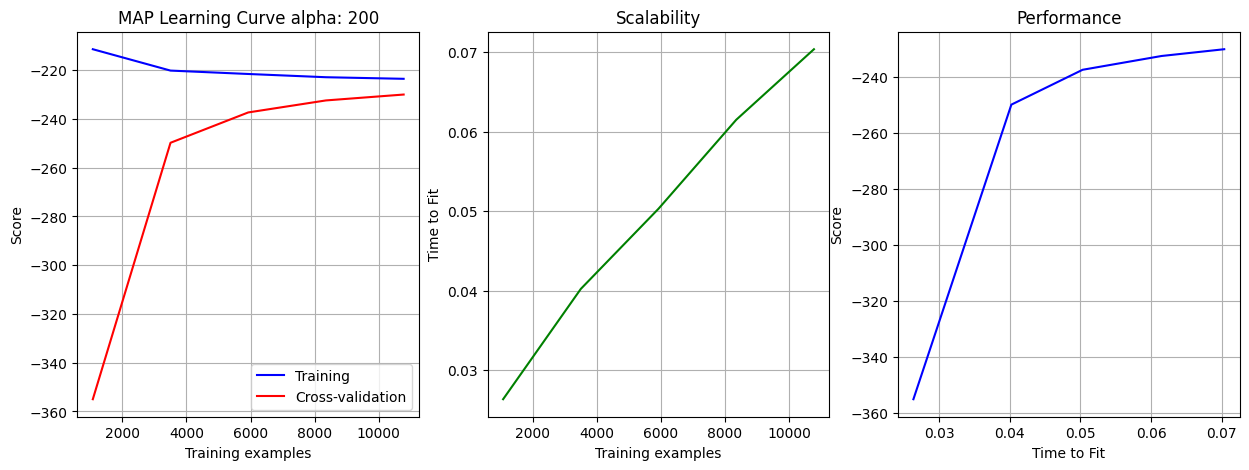

In [14]:
for a in (1, 10, 50, 100, 200):
    for alpha_class_itr in (0.1, 0.2, 0.5, 1, 10, 100):
        map = MaximumAPosterioriClassifier(alpha=[a] * 47, beta=[1, 1])
        map.fit(X_train, y_train)
        map.predict(X_train)
        customSplit = CustomShuffleSplit(n_splits=12, test_size=0.9, train_size=0.1, 
                                      random_state=0, y=y, alpha_class=alpha_class_itr)
        plt = plot_learning_curves(map, f'MAP Learning Curve alpha: {a}', X, y, n_jobs=1,cv=customSplit)
        plt.show()

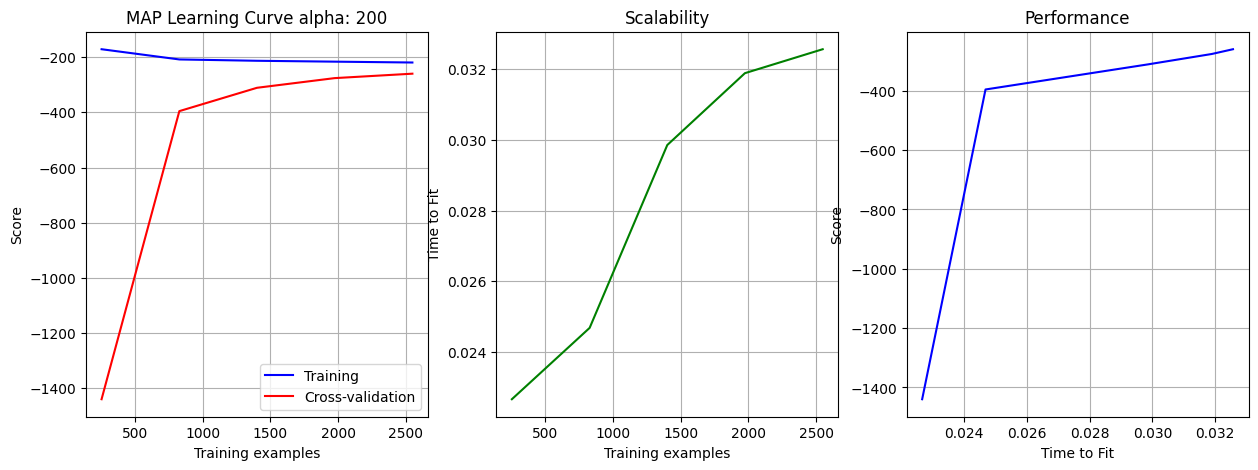

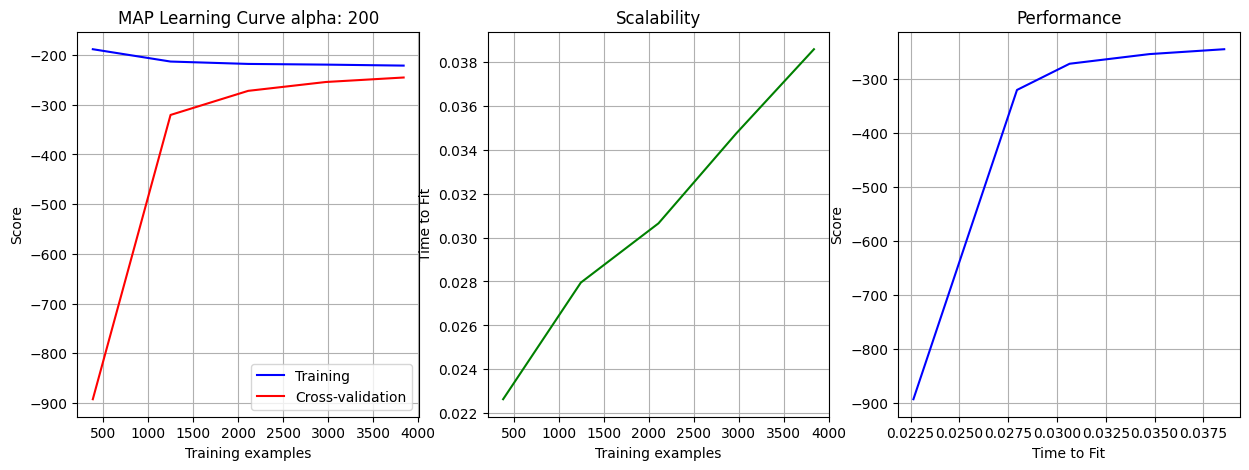

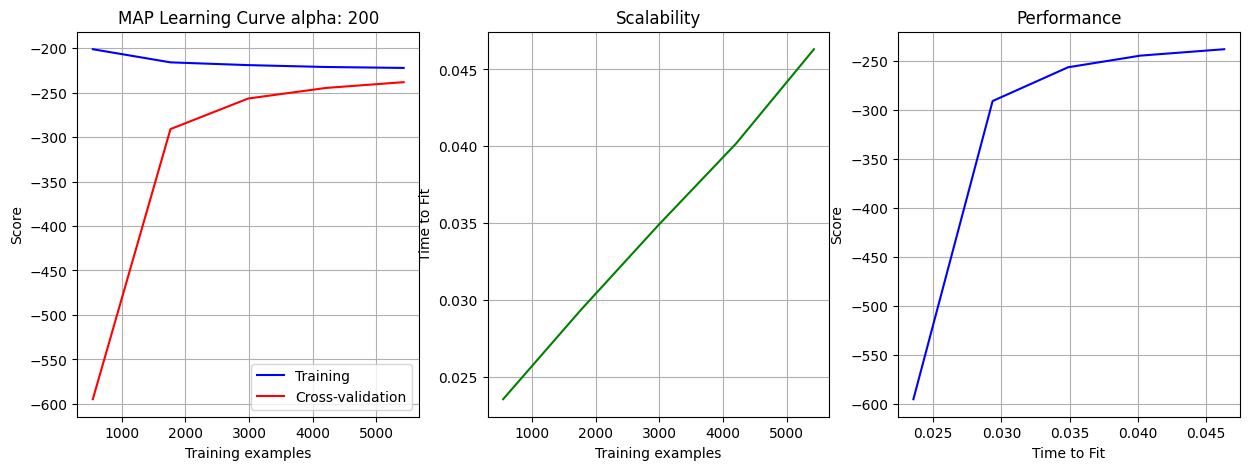

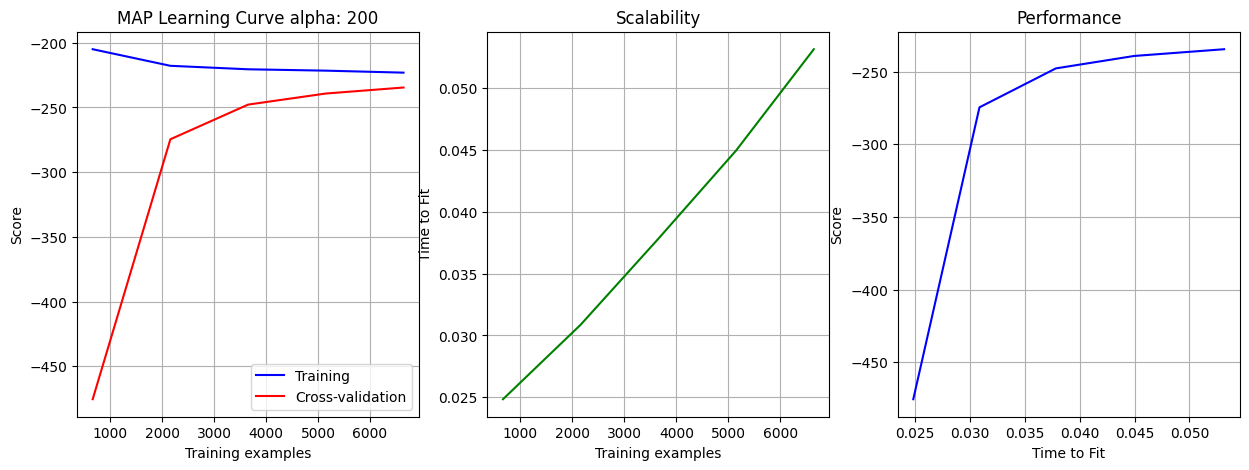

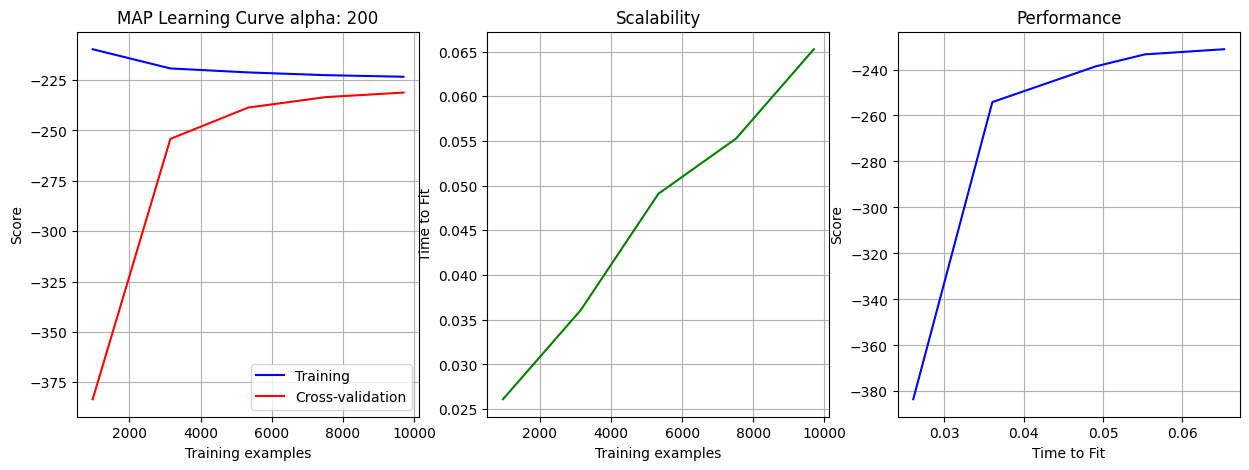

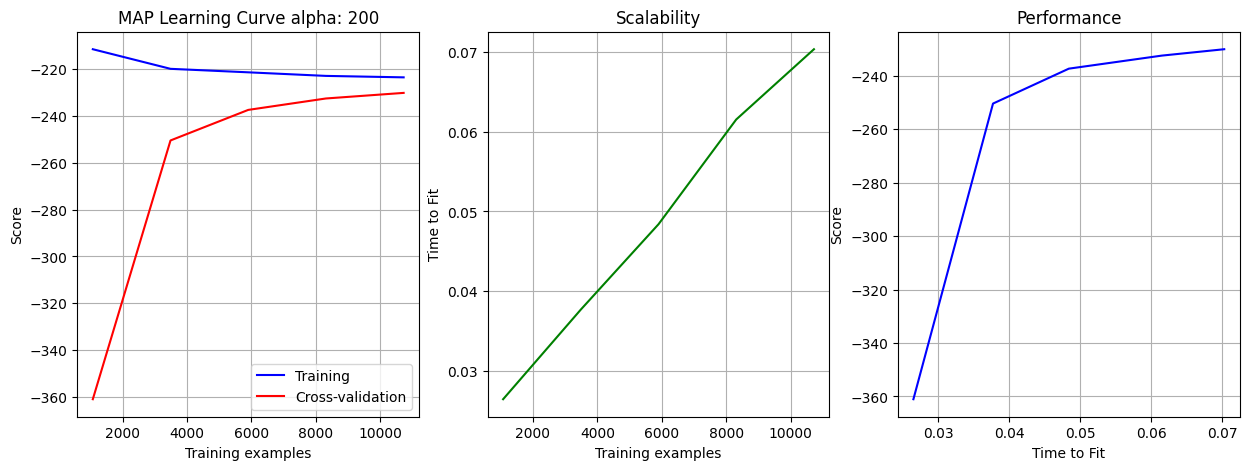

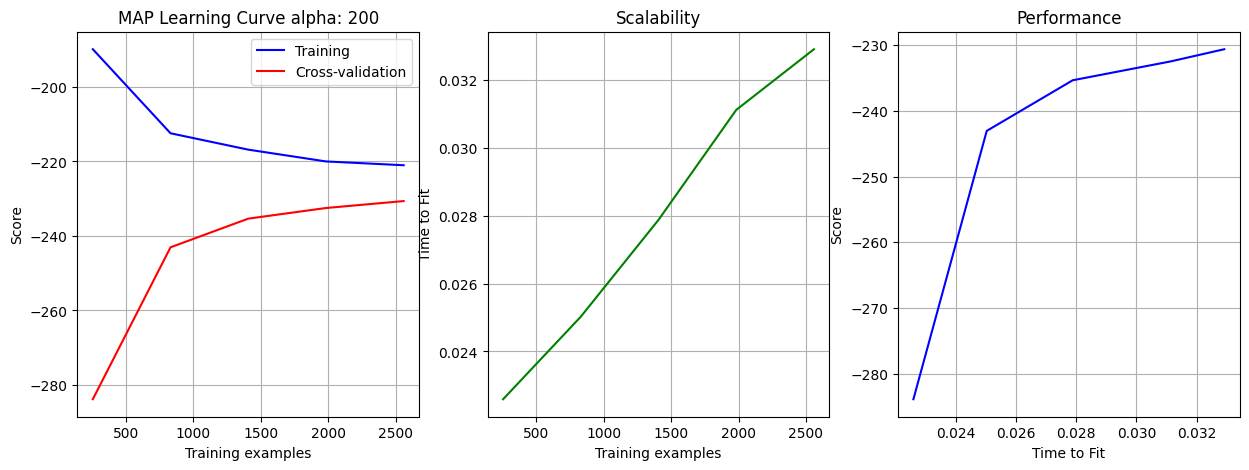

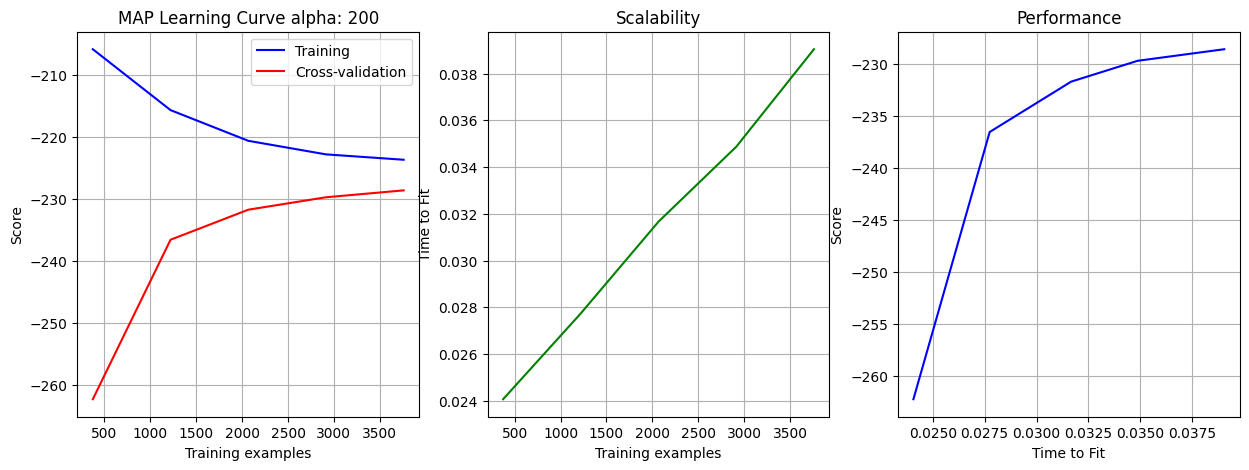

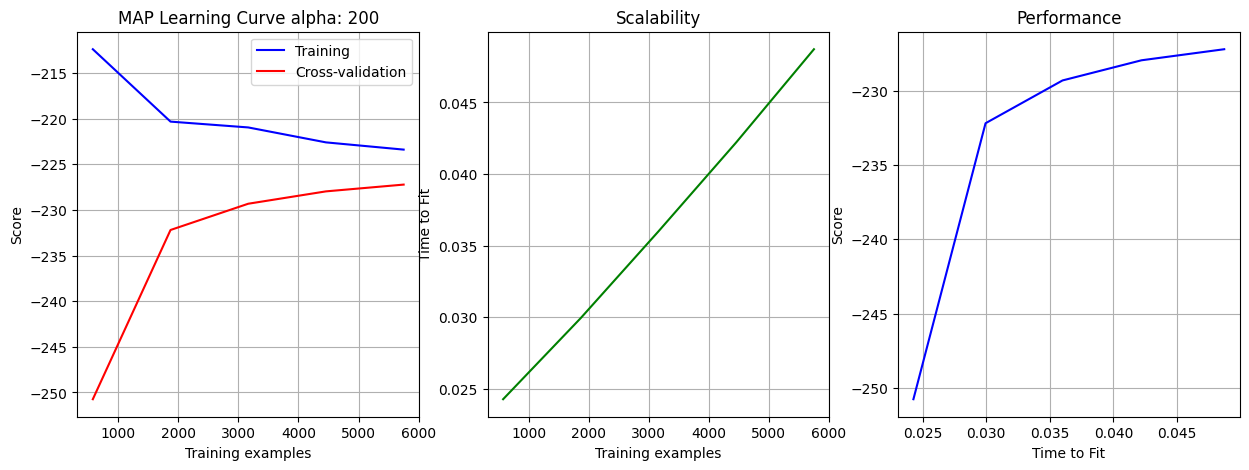

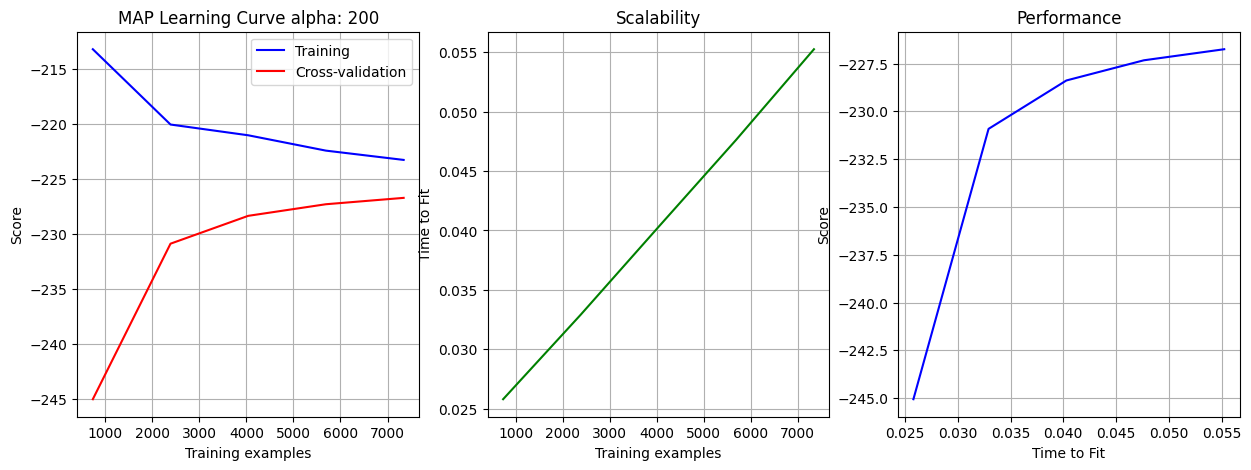

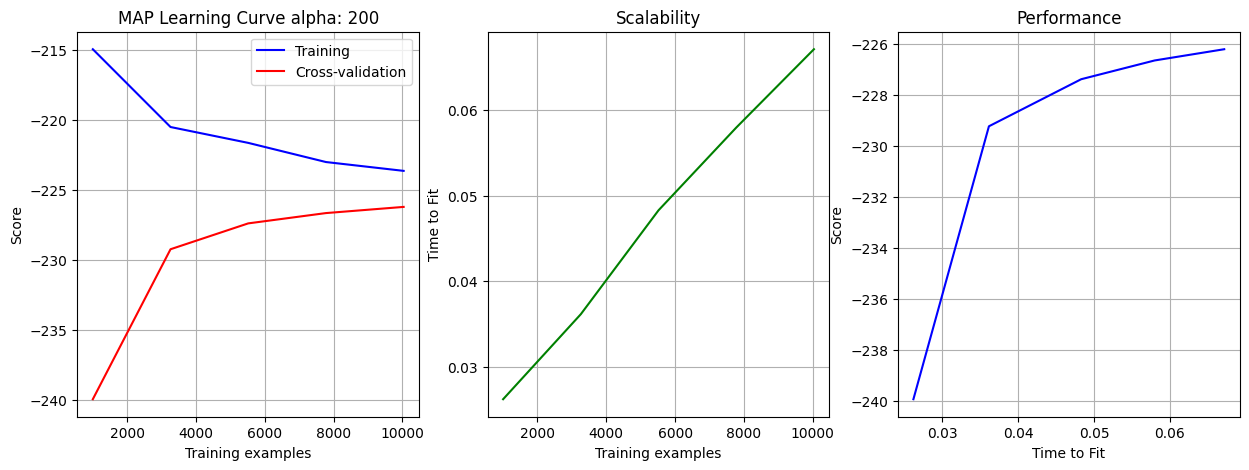

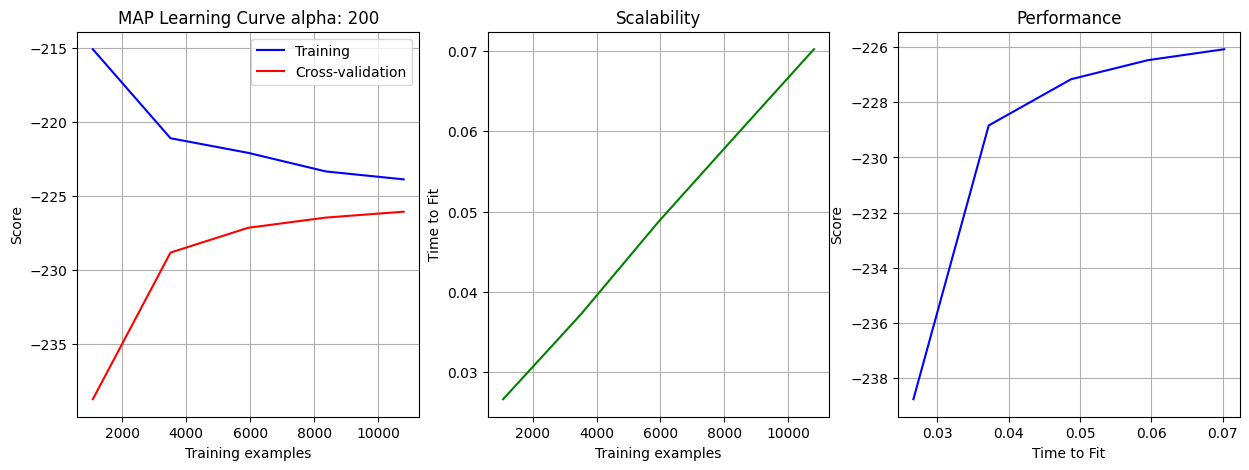

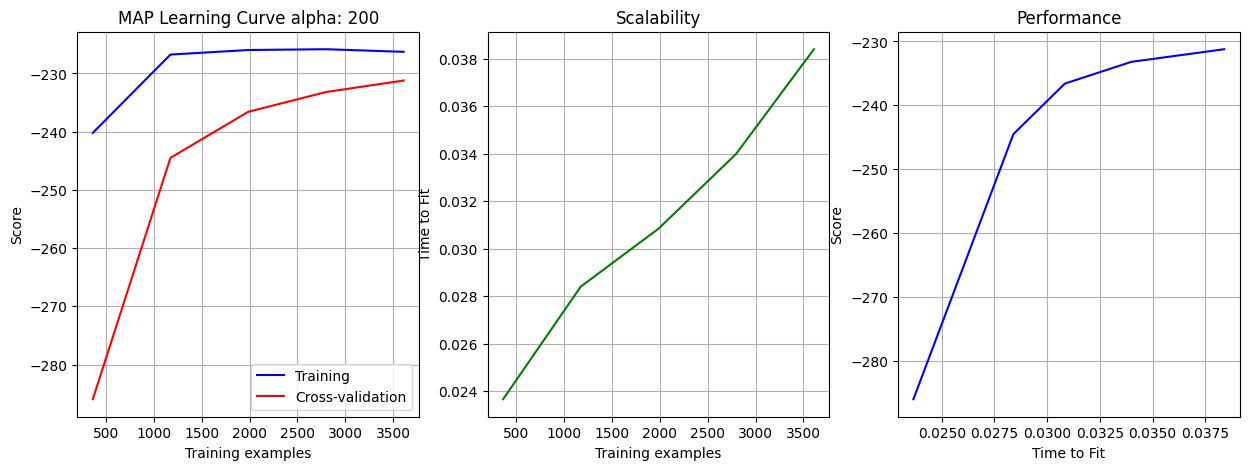

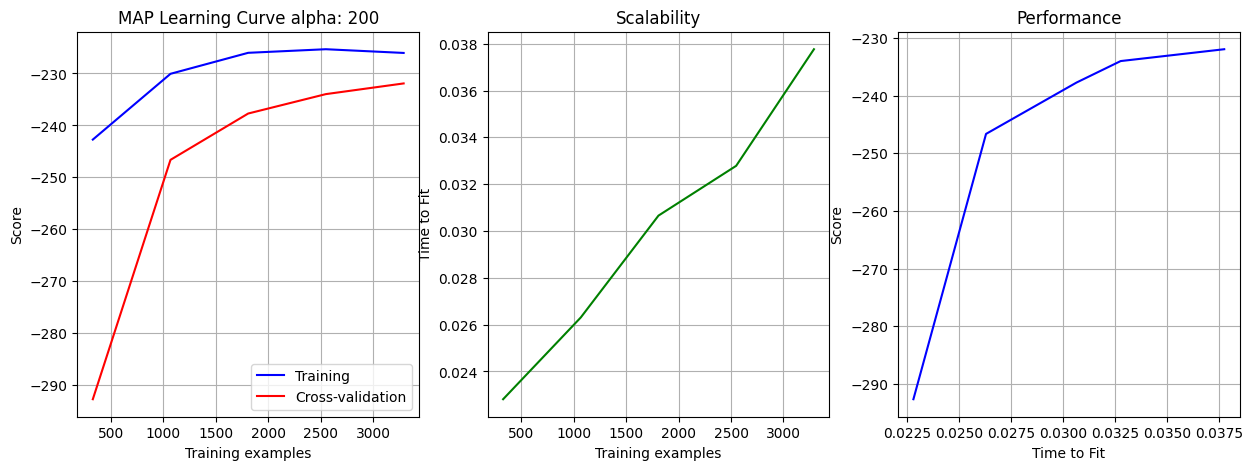

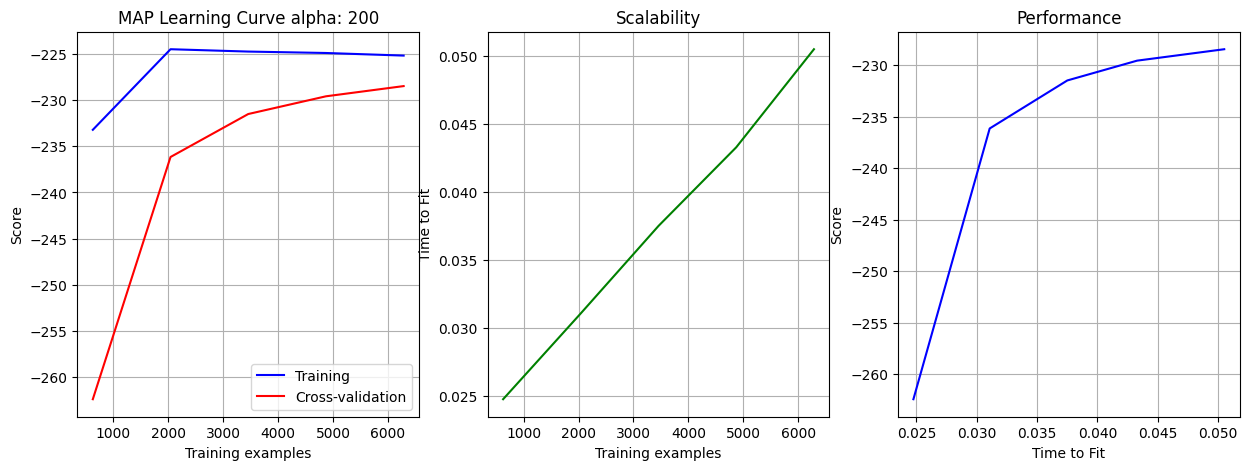

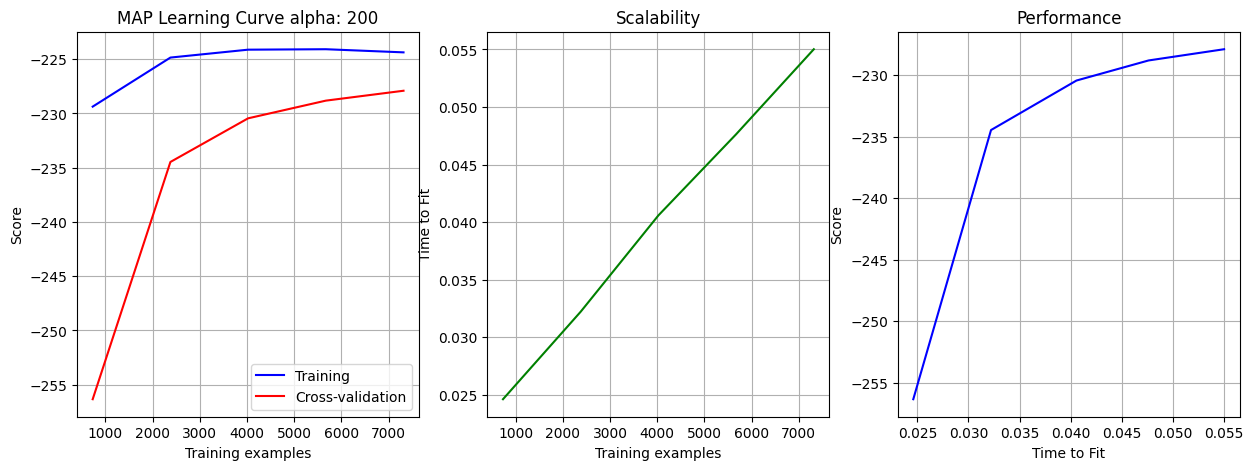

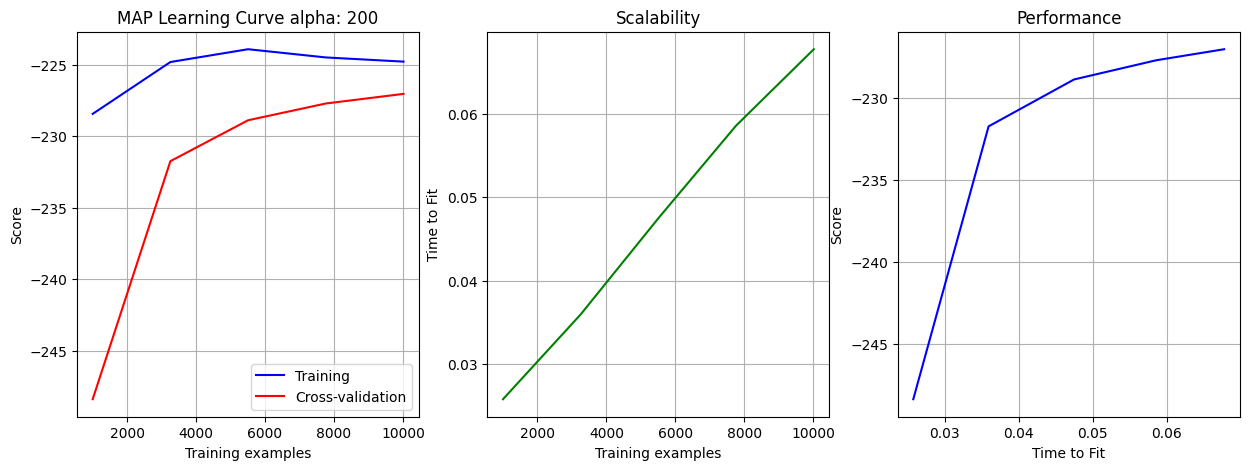

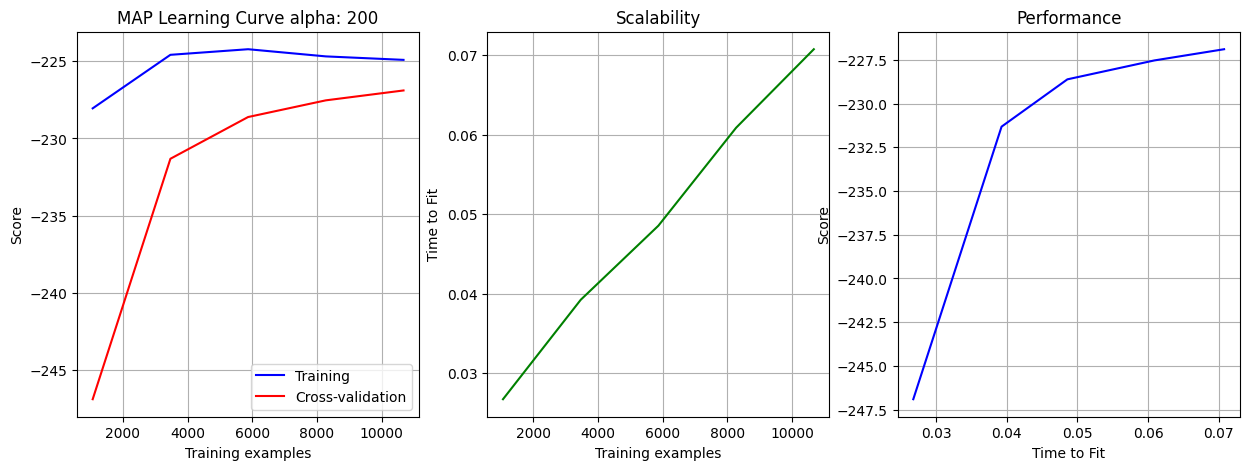

/var/folders/1c/flplcvwd7td1z95vc702_4fh0000gp/T/ipykernel_67977/1090731603.py:57: RuntimeWarning: divide by zero encountered in log
  posterior = prob_est + np.log(self.class_prior[c])


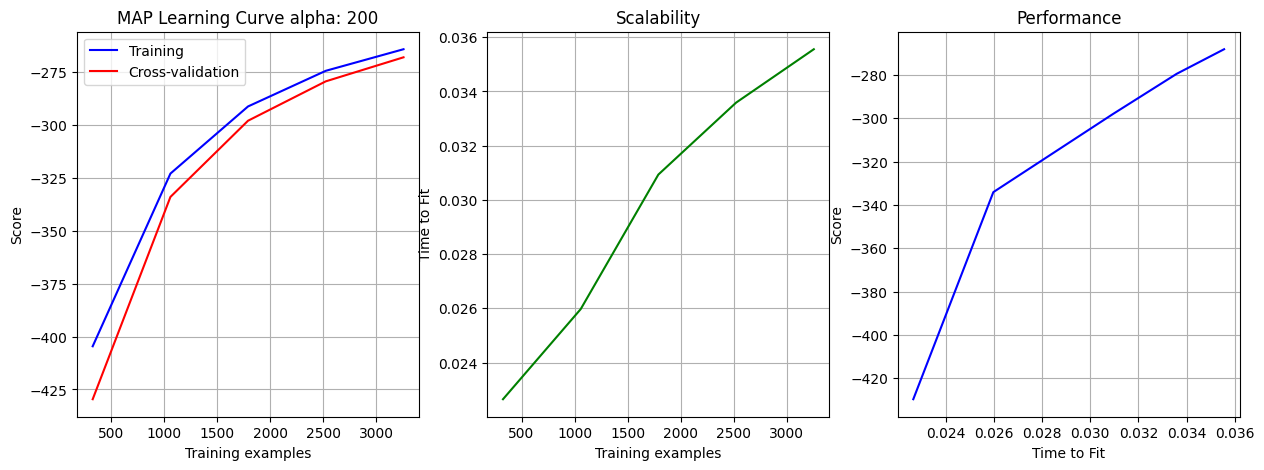

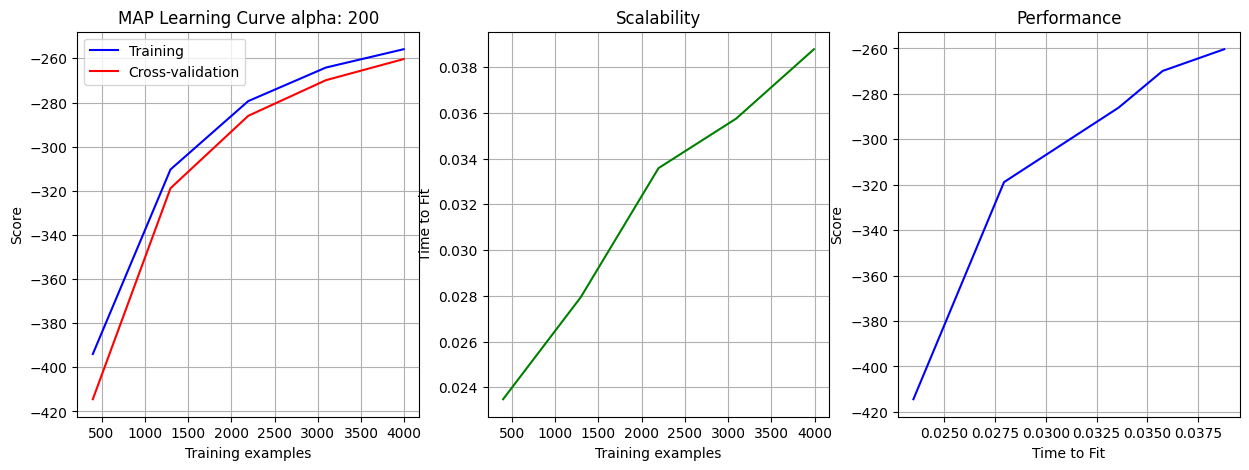

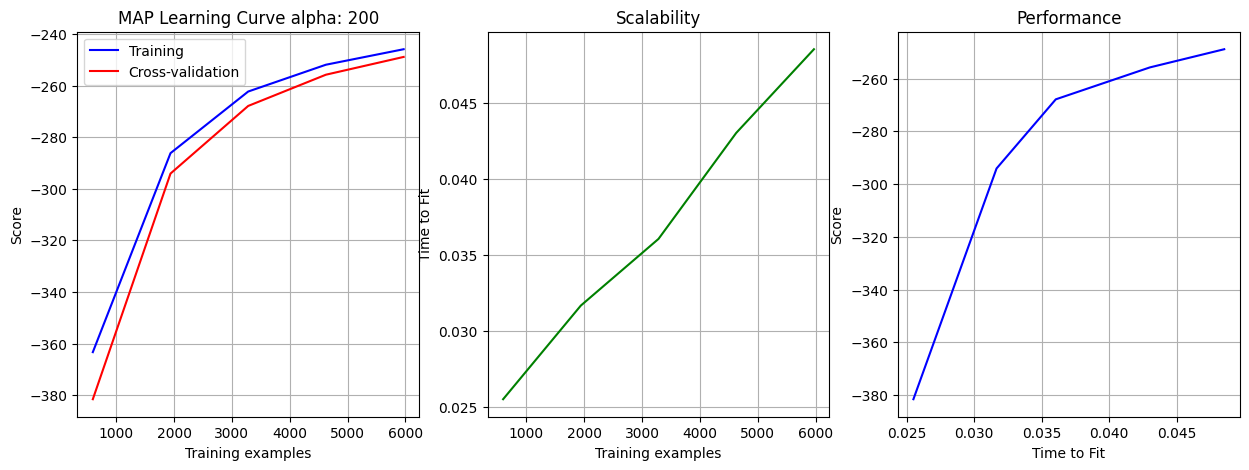

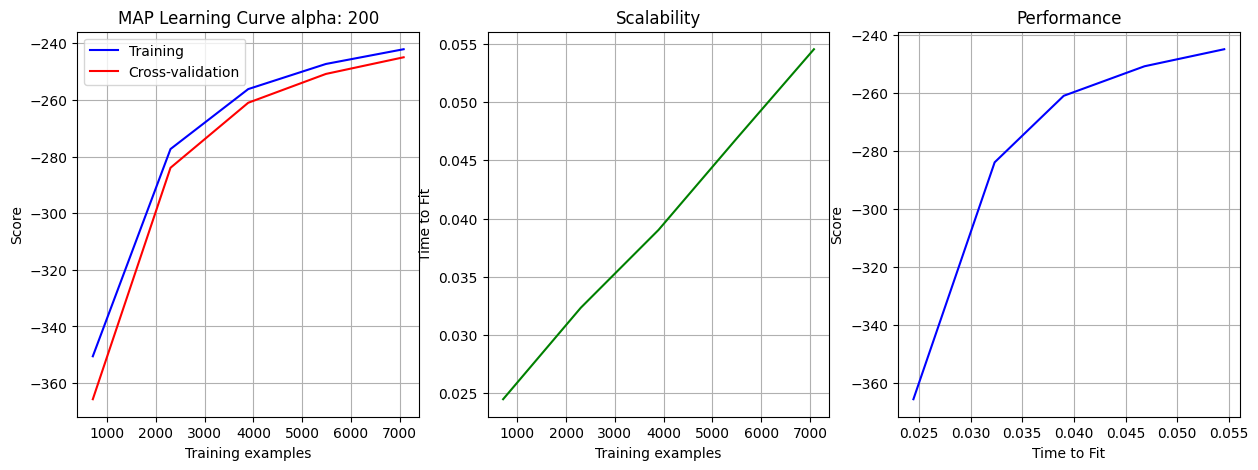

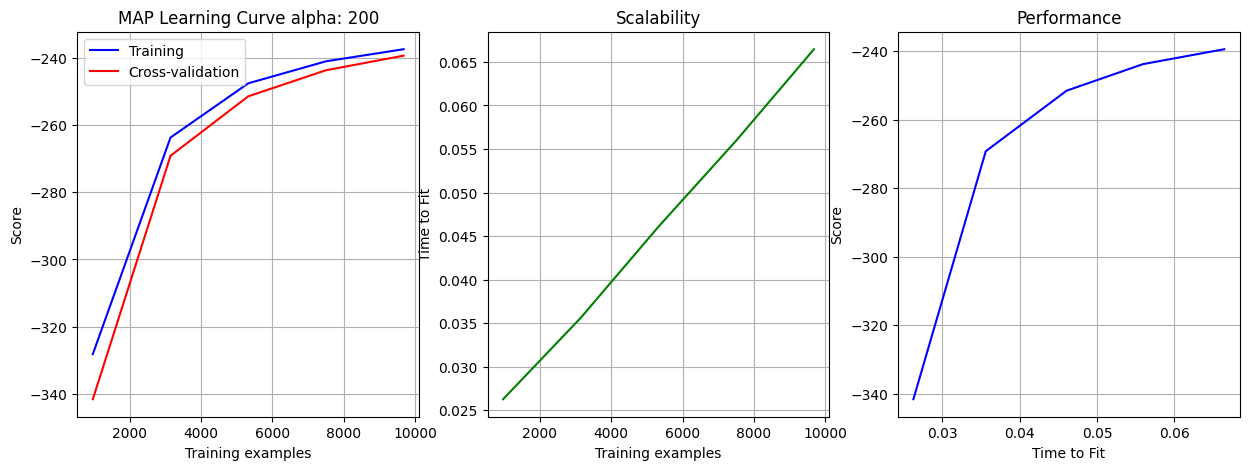

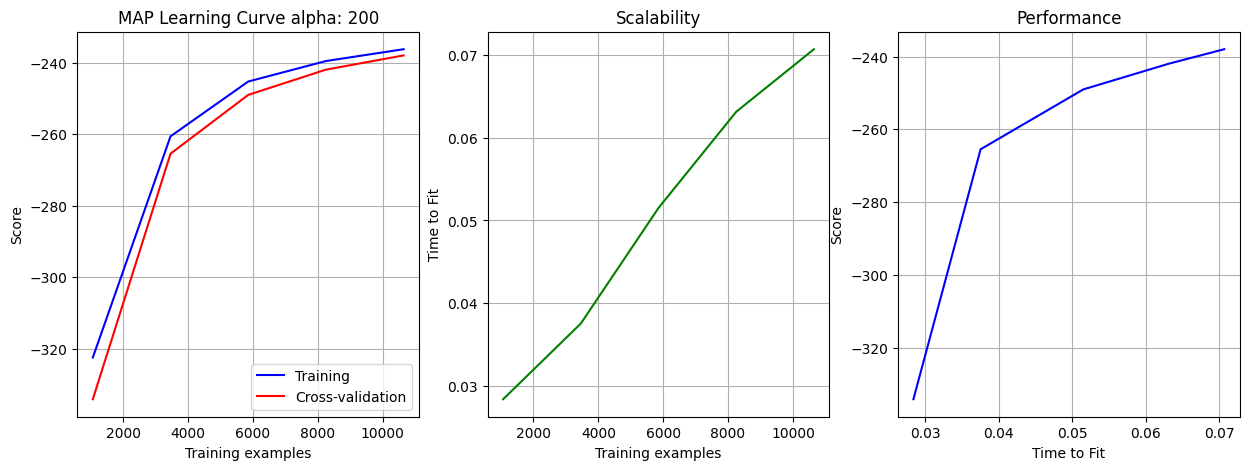

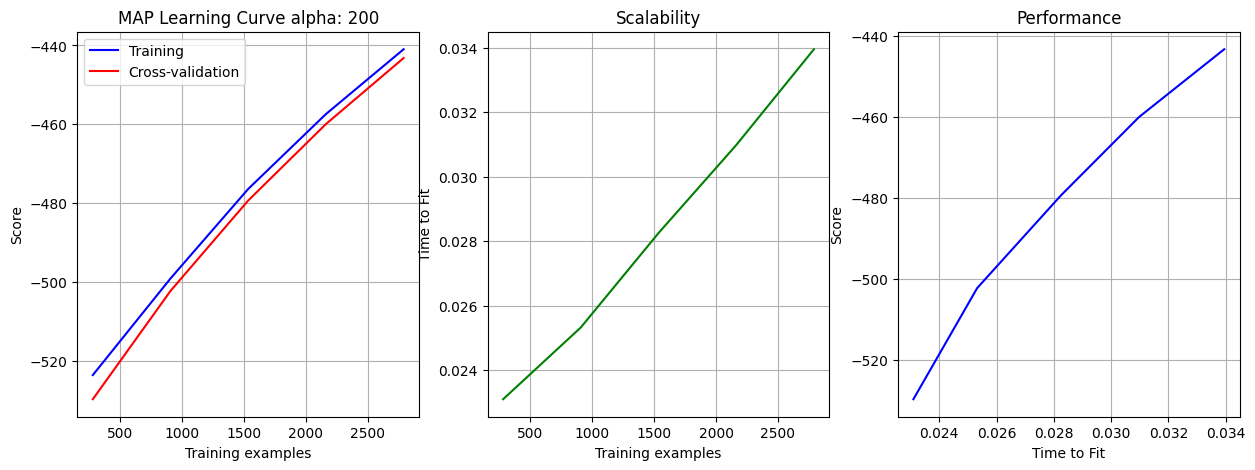

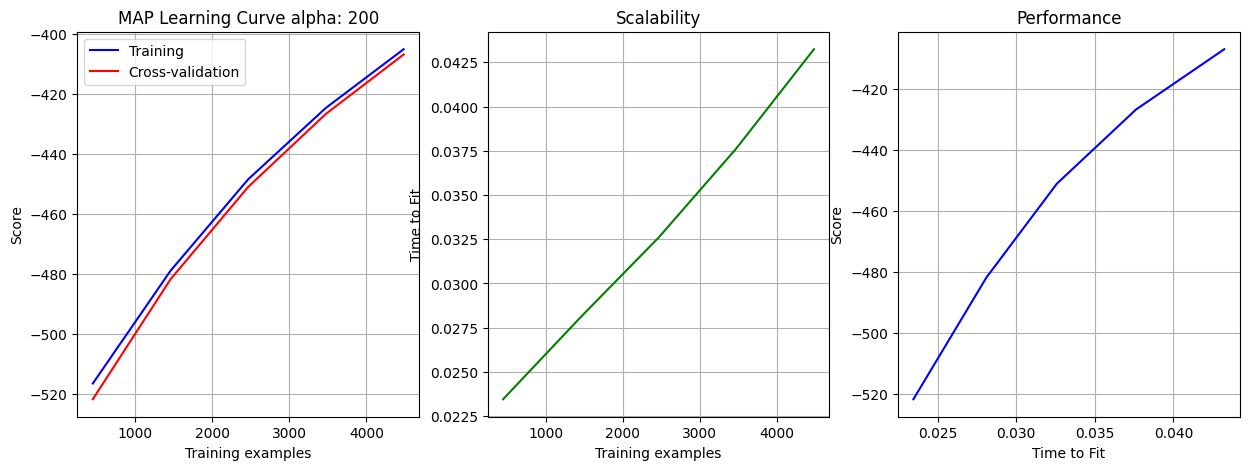

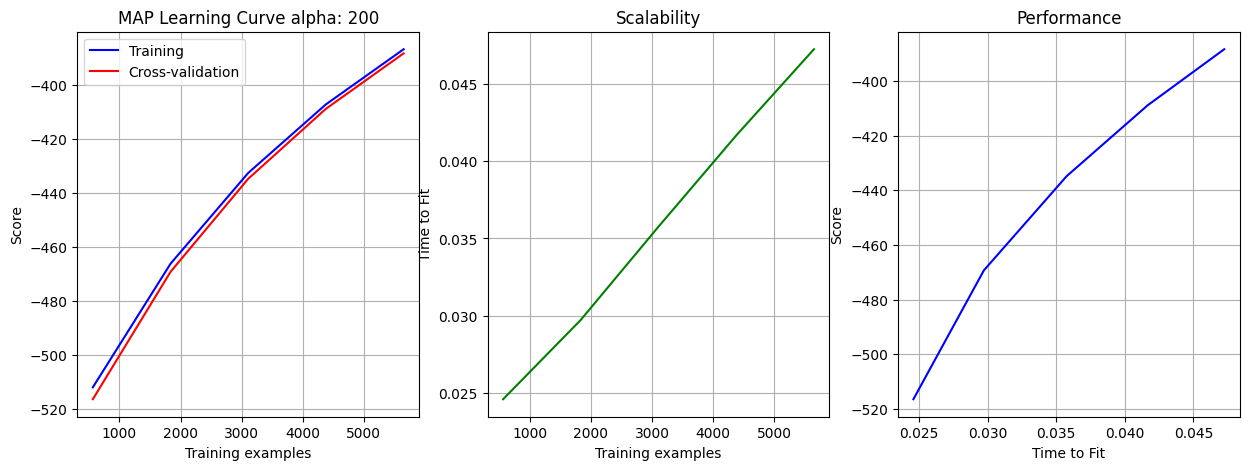

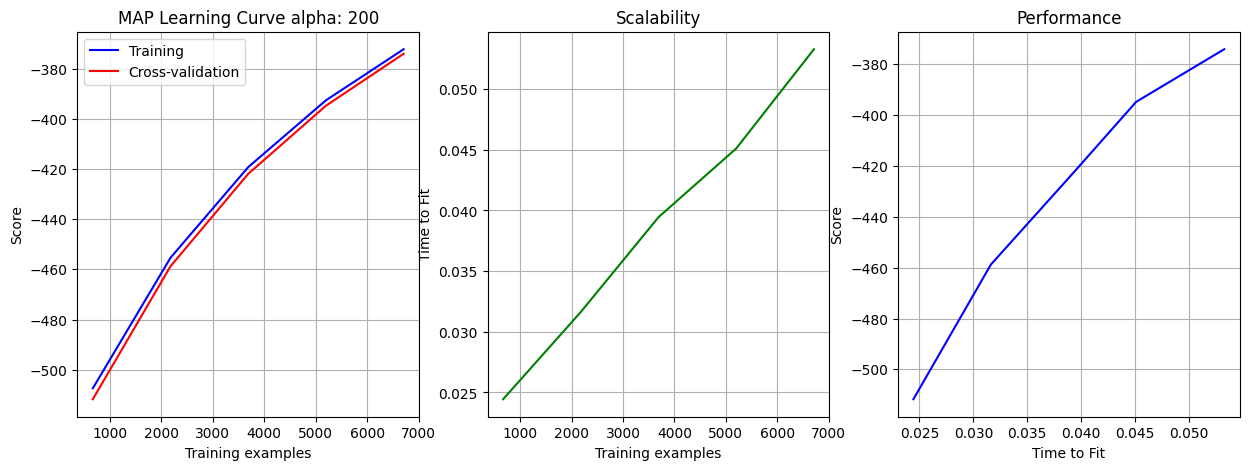

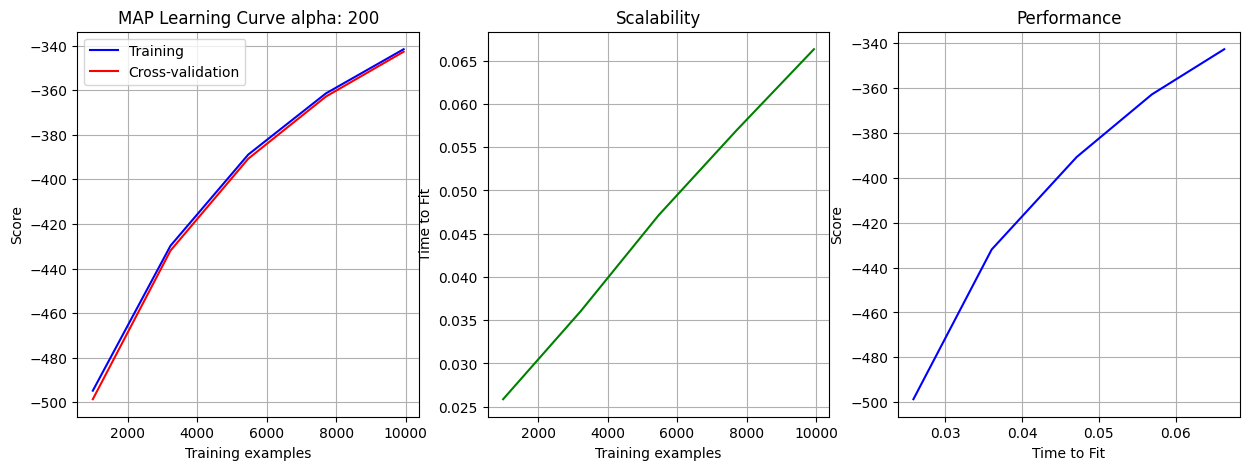

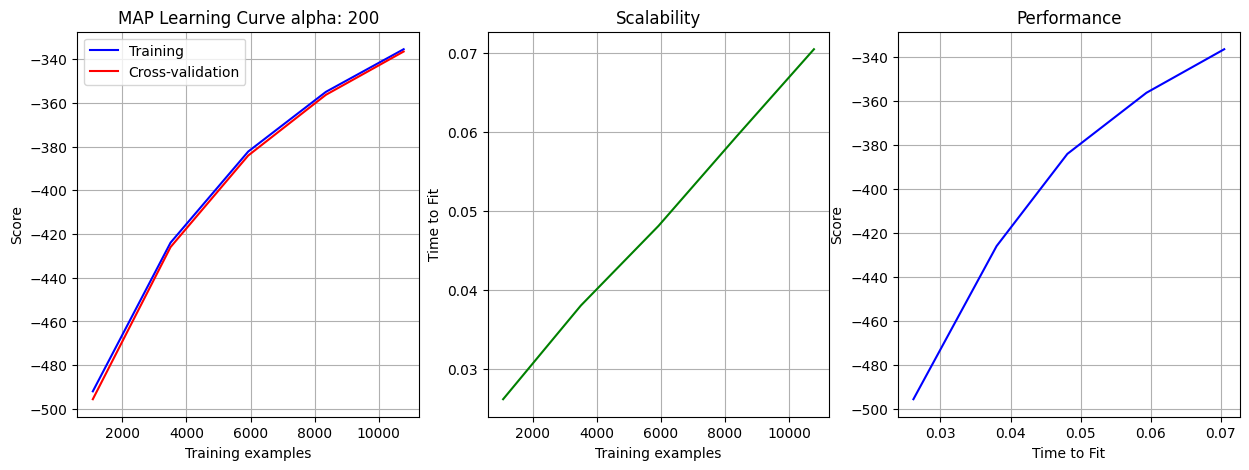

In [15]:
for b in (1, 1.2, 2, 10, 100):
    for alpha_class_itr in (0.1, 0.2, 0.5, 1, 10, 100):
        map = MaximumAPosterioriClassifier(alpha=[1] * 47, beta=[b, b])
        map.fit(X_train, y_train)
        map.predict(X_train)
        customSplit = CustomShuffleSplit(n_splits=12, test_size=0.9, train_size=0.1, 
                                      random_state=0, y=y, alpha_class=alpha_class_itr)
        plt = plot_learning_curves(map, f'MAP Learning Curve alpha: {a}', X, y, n_jobs=1,cv=customSplit)
        plt.show()

Task 5.1: How does the generalization performance of each model change as a function of the amount of training data and the choice of hyper-parameters?

Generalization Performance Trends:

As the α_class parameter increases, the training data becomes more balanced and the effective amount increases. This improves generalization performance (cross-validation score) for both MLE and MAP models.

MLE has no hyperparameters, so its performance steadily improves with more balanced data via higher α_class.

For MAP, increasing α keeps β constant at 1. This shows minor improvements with more data.

Increasing β from 1 to 100 for MAP significantly decreases performance. This indicates the pixel prior assumption enforced by higher β values hurts generalization.

At α_class=100, MAP and MLE are nearly identical since data is almost balanced.


Task 5.2: Which model would you select for deployment and why?

Model Selection:

I would select the MAP model for deployment because:

It achieves slightly better performance than MLE with tuned hyperparameters.

The ability to tune priors is valuable for adapting to new datasets.

Priors allow incorporating domain knowledge to compensate for limited data.

MAP provides uncertainty estimates from its probabilistic framework.

However, MLE is more robust and adaptive since it relies solely on data. For deployment, MAP's advantages outweigh its complexity, but both are reasonable choices depending on context.